# Companion Notebook to `playing-with-coronavirus-data` 
- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"** -08/12/21

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

In [1]:
RUN_FULL_WORKFLOW=False

In [5]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys,joblib
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

import statsmodels.tsa.api as tsa

In [6]:
%load_ext autoreload
%autoreload 2
import data_acquisition as da
import coronavirus_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

In [7]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES=da.FULL_WORKFLOW()
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_csv('data/combined_us_states_full_data.csv')
    STATES = joblib.load('data/STATE_DICT.joblib')

display(df_states.head())
STATES.keys()

[i] Using previously downloaded data...


State_Code  ... percent_of_inpatients_with_covid_denominator
0         AK  ...                                         21.0
1         AK  ...                                         20.0
2         AK  ...                                         15.0
3         AK  ...                                         16.0
4         AK  ...                                         23.0

[5 rows x 44 columns]

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# EDA

In [24]:
old_df = covid.df_states.copy()
old_md = old_df.groupby('state').get_group('MD').copy()
# old_md = old_md.set_index('date').sort_index()
old_md

state  fips  ...  deathIncrease  hospitalizedIncrease
date                    ...                                     
2021-03-07    MD    24  ...             14                    79
2021-03-06    MD    24  ...             11                   194
2021-03-05    MD    24  ...              8                    74
2021-03-04    MD    24  ...              3                    81
2021-03-03    MD    24  ...             14                    71
...          ...   ...  ...            ...                   ...
2020-03-09    MD    24  ...              0                     0
2020-03-08    MD    24  ...              0                     0
2020-03-07    MD    24  ...              0                     0
2020-03-06    MD    24  ...              0                     0
2020-03-05    MD    24  ...              0                     0

[368 rows x 24 columns]

## Selecting Final Hospital Columns to Use

### Comparing to Old Data

In [26]:
compare_state='MD'

In [28]:
def get_state(STATES, state='NY',drop_cols=True,drop_exprs=['coverage','denominator',
                                                           'numerator']):
    df_state= STATES[state].copy()
    
    
    if drop_cols:
        cols_to_drop = []
        for expr in drop_exprs:
            cols_to_drop.extend([c for c in df_state.columns if expr.lower() in c.lower()])
        df_state = df_state.drop(columns=cols_to_drop)
        
    return df_state

In [27]:
## OLD DATA
covid = fn.CovidTrackingProject(verbose=True)
# covid

old_df = covid.df_states.copy()
old_md = old_df.groupby('state').get_group(compare_state).copy()
# old_md = old_md.set_index('date').sort_index()
old_md

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
ERROR
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"


state  fips  ...  deathIncrease  hospitalizedIncrease
date                    ...                                     
2021-03-07    MD    24  ...             14                    79
2021-03-06    MD    24  ...             11                   194
2021-03-05    MD    24  ...              8                    74
2021-03-04    MD    24  ...              3                    81
2021-03-03    MD    24  ...             14                    71
...          ...   ...  ...            ...                   ...
2020-03-09    MD    24  ...              0                     0
2020-03-08    MD    24  ...              0                     0
2020-03-07    MD    24  ...              0                     0
2020-03-06    MD    24  ...              0                     0
2020-03-05    MD    24  ...              0                     0

[368 rows x 24 columns]

In [57]:
md = get_state(STATES,'MD',drop_exprs=[])
new_md = md.loc[old_df.index[-1]:old_df.index[0]].copy()
new_md

Cases  ...  percent_of_inpatients_with_covid_denominator
Date                ...                                              
2020-03-01       0  ...                                           4.0
2020-03-02       0  ...                                           4.0
2020-03-03       0  ...                                           4.0
2020-03-03       0  ...                                           4.0
2020-03-04       0  ...                                           4.0
...            ...  ...                                           ...
2021-03-03  383956  ...                                        9561.0
2021-03-04  384765  ...                                        9599.0
2021-03-05  385678  ...                                        9499.0
2021-03-06  386610  ...                                        9198.0
2021-03-07  387319  ...                                        9103.0

[369 rows x 42 columns]

### Compare Plots

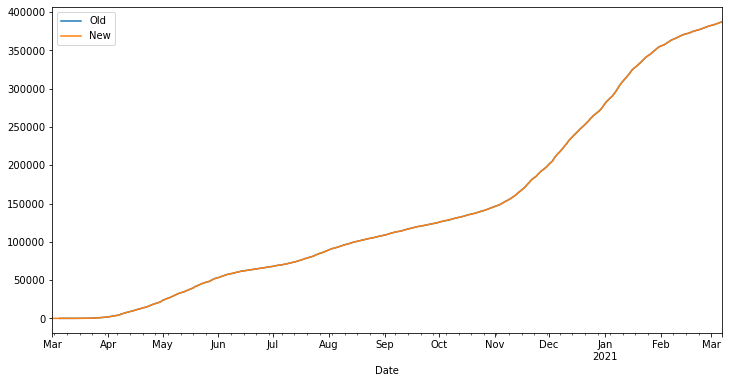

In [58]:
ax = old_md['positive'].plot(label='Old')
new_md['Cases'].plot(ax=ax,label='New')
ax.legend()

In [59]:
new_md[[c for c in new_md.columns if 'icu' in c.lower()]]

total_staffed_adult_icu_beds_coverage  ...  adult_icu_bed_covid_utilization
Date                                              ...                                 
2020-03-01                                     0  ...                              NaN
2020-03-02                                     0  ...                              NaN
2020-03-03                                     0  ...                              NaN
2020-03-03                                     0  ...                              NaN
2020-03-04                                     0  ...                              NaN
...                                          ...  ...                              ...
2021-03-03                                    61  ...                         0.176861
2021-03-04                                    61  ...                         0.179295
2021-03-05                                    61  ...                         0.183370
2021-03-06                                    61  ...                         0.194052
2021-03-07                                    61  ...                         0.194529

[369 rows x 12 columns]

## BOOKMARK- COMPARING HOSPITAL COLUMNS

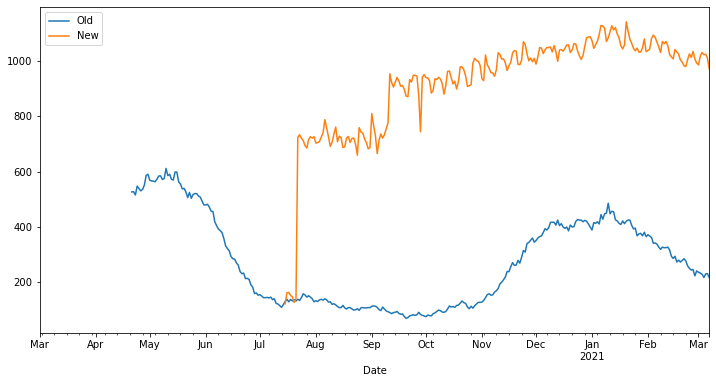

In [60]:
ax = old_md['inIcuCurrently'].plot(label='Old')
new_md['staffed_adult_icu_bed_occupancy'].plot(ax=ax,label='New')
ax.legend()

In [ ]:
old_df['inIcuCumulative']

------------------------------------------------------------
Cases


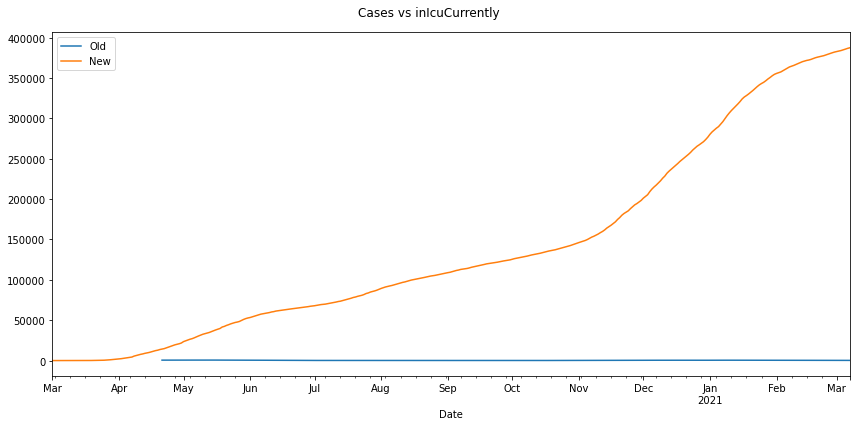




------------------------------------------------------------
Deaths


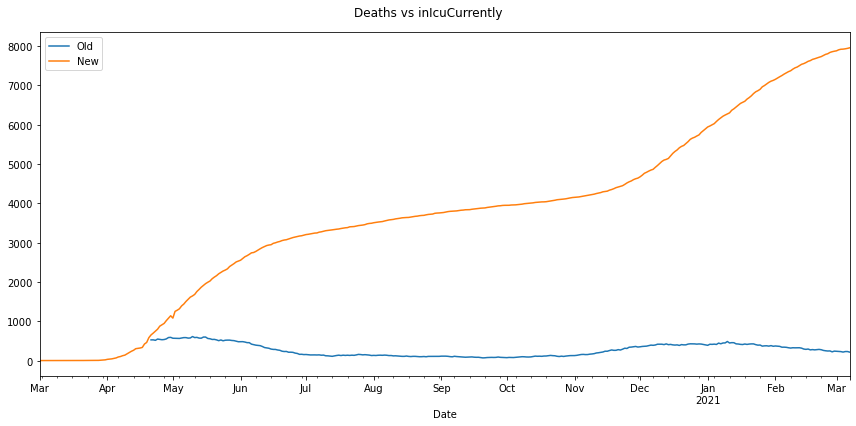




------------------------------------------------------------
inpatient_beds_utilization


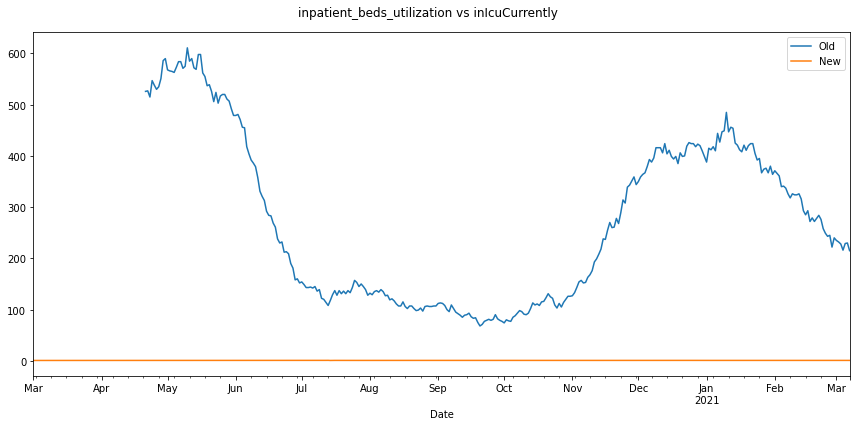




------------------------------------------------------------
total_staffed_adult_icu_beds_coverage


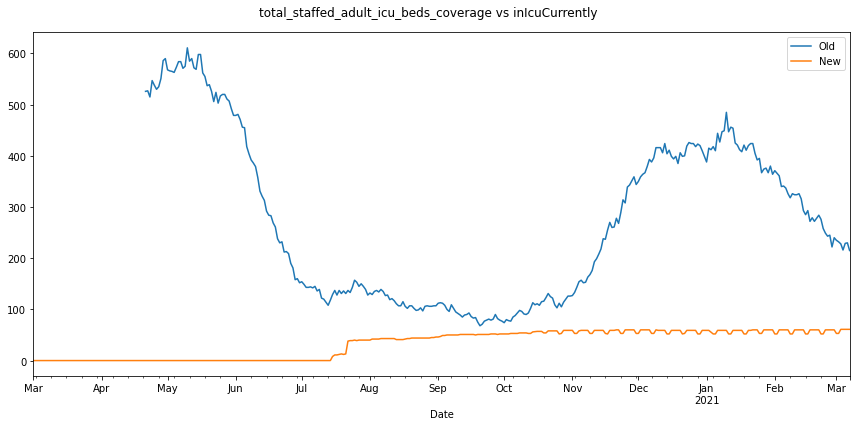




------------------------------------------------------------
adult_icu_bed_covid_utilization_coverage


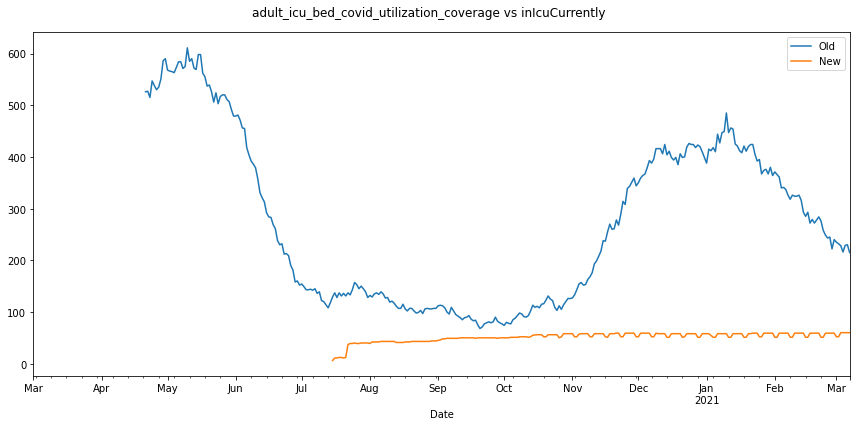




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage


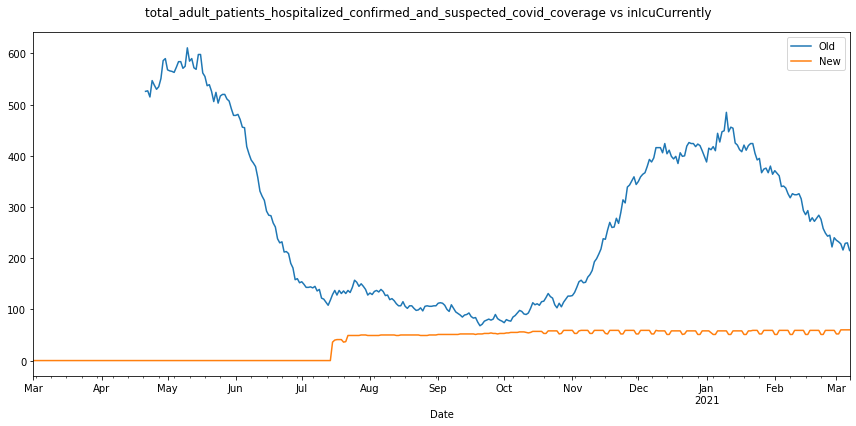




------------------------------------------------------------
percent_of_inpatients_with_covid_coverage


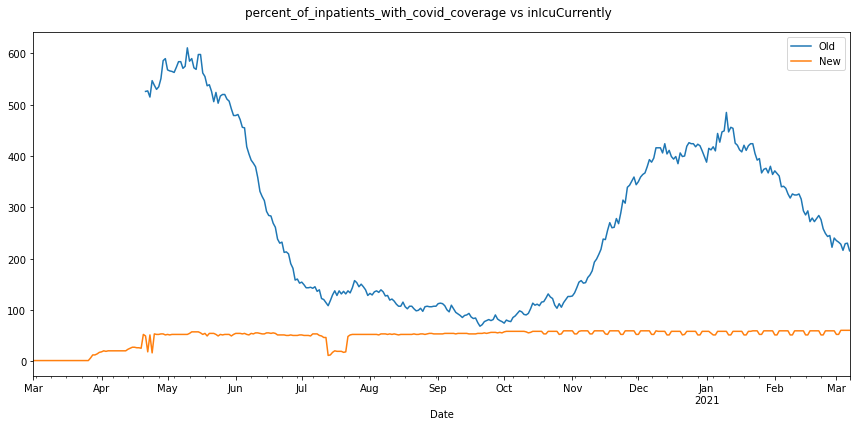




------------------------------------------------------------
staffed_adult_icu_bed_occupancy_coverage


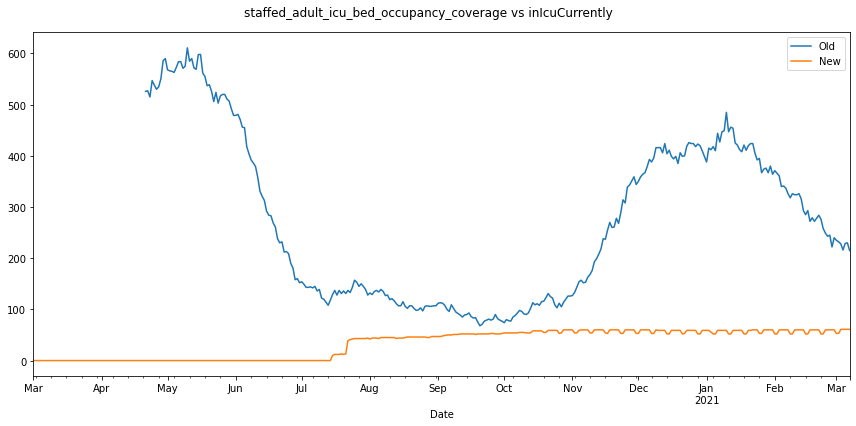




------------------------------------------------------------
inpatient_beds_used_covid_coverage


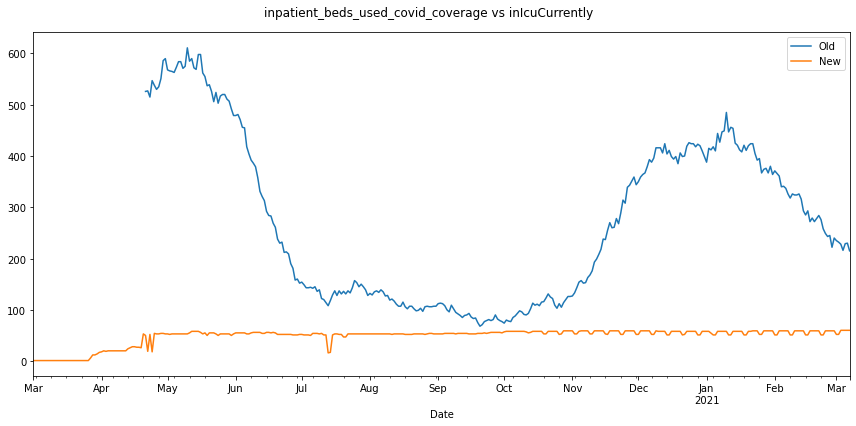




------------------------------------------------------------
inpatient_beds_utilization_numerator


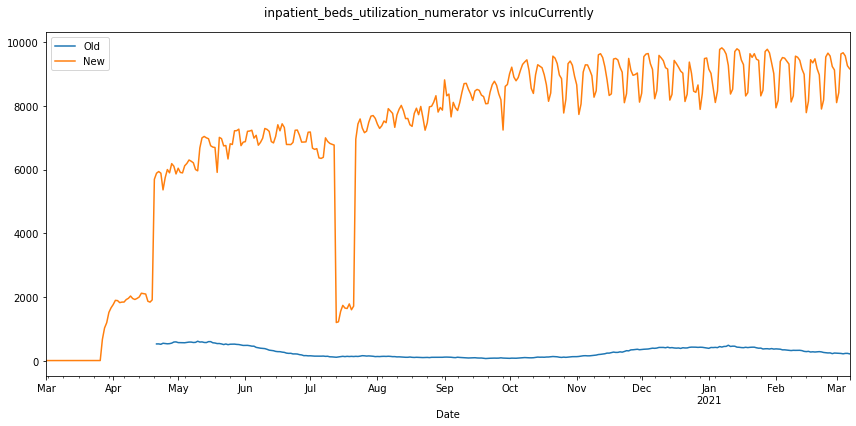




------------------------------------------------------------
inpatient_beds_used_covid


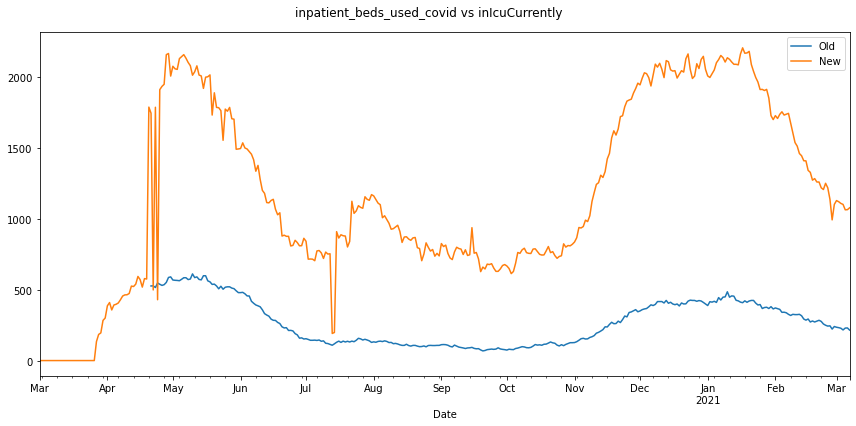




------------------------------------------------------------
total_staffed_adult_icu_beds


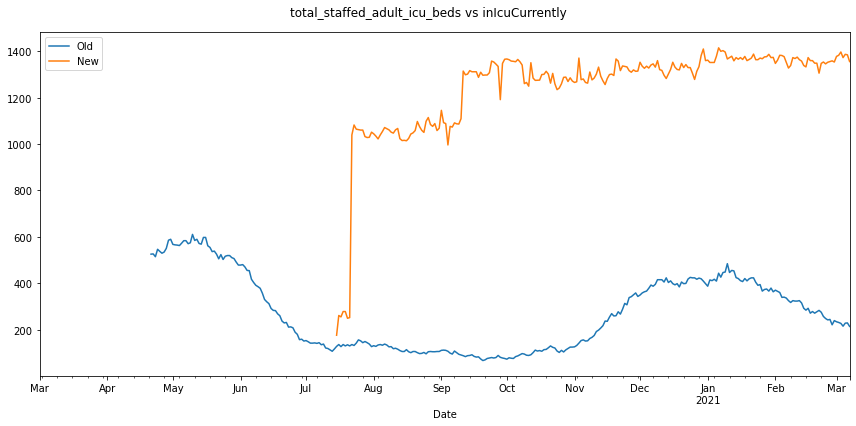




------------------------------------------------------------
inpatient_bed_covid_utilization_coverage


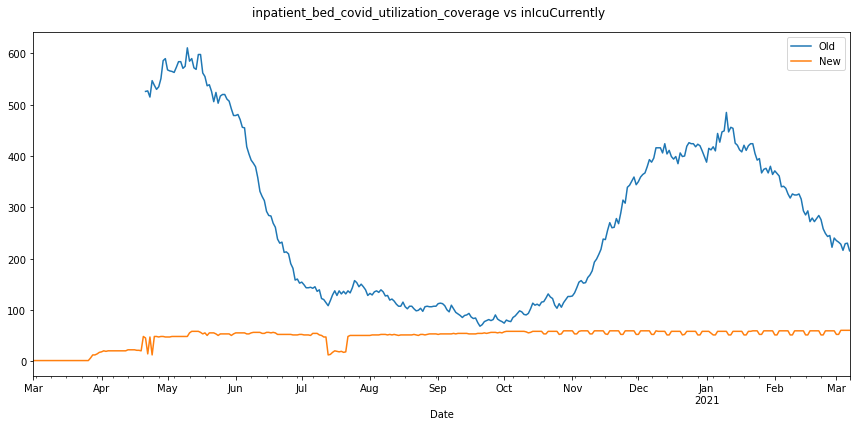




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid


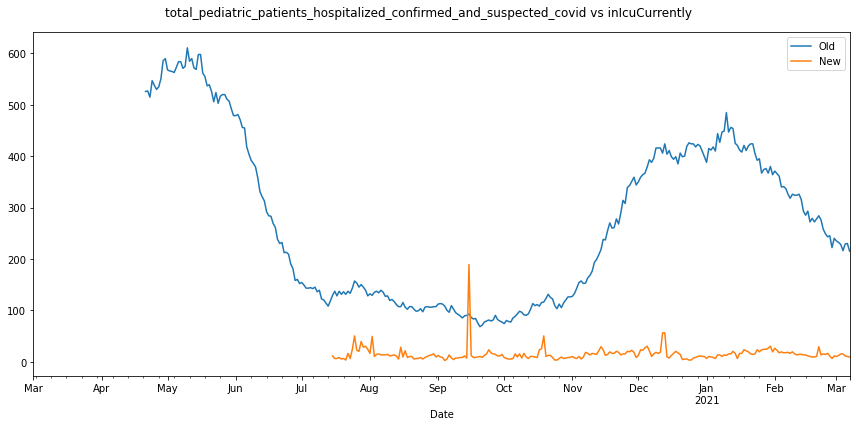




------------------------------------------------------------
inpatient_beds


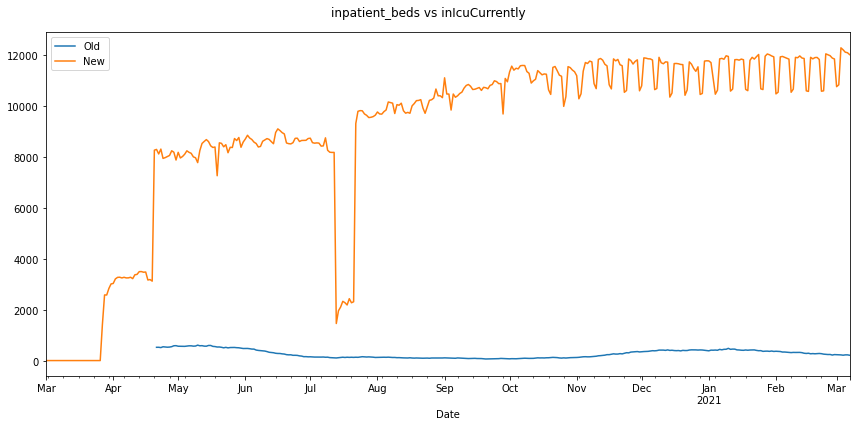




------------------------------------------------------------
adult_icu_bed_utilization_denominator


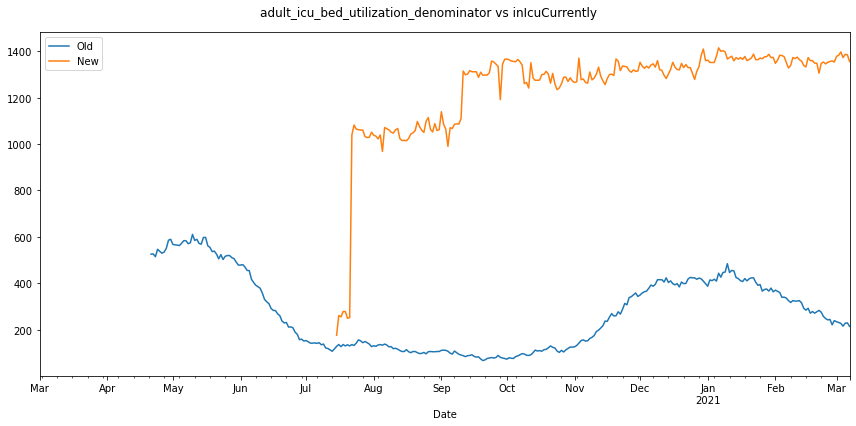




------------------------------------------------------------
adult_icu_bed_covid_utilization_numerator


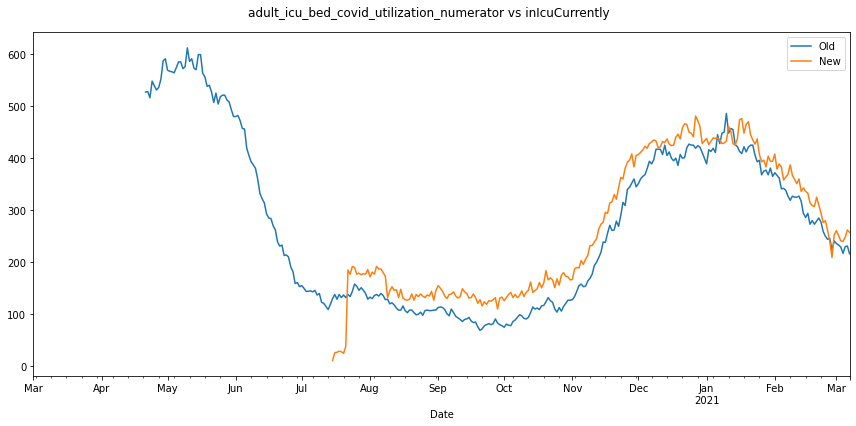




------------------------------------------------------------
adult_icu_bed_covid_utilization_denominator


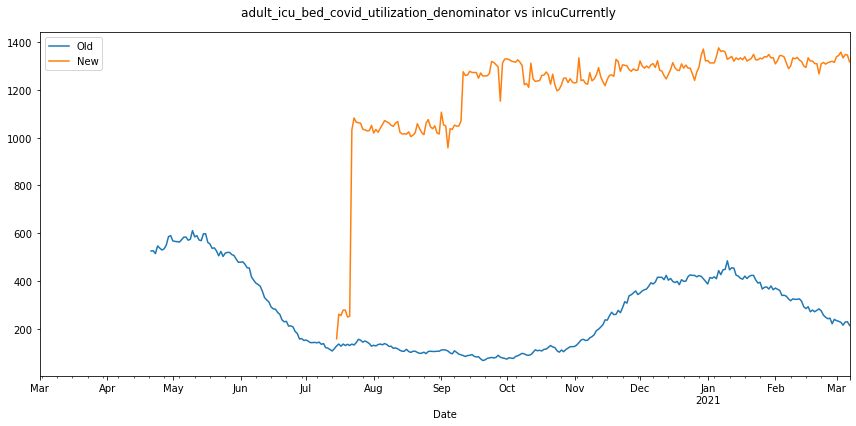




------------------------------------------------------------
adult_icu_bed_utilization


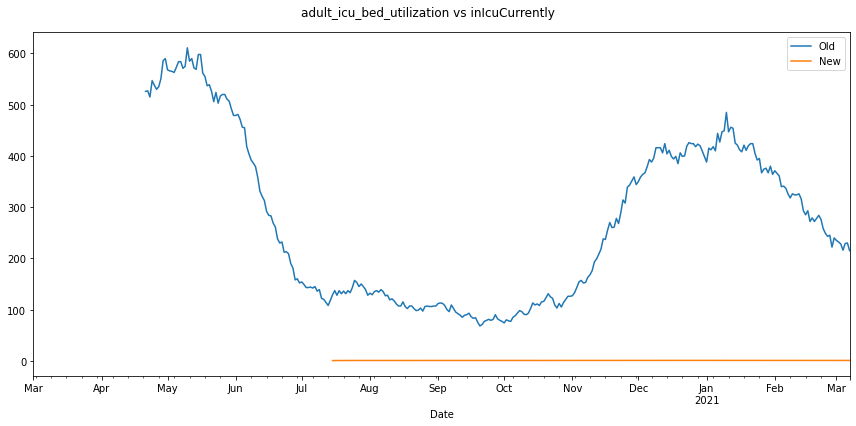




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage


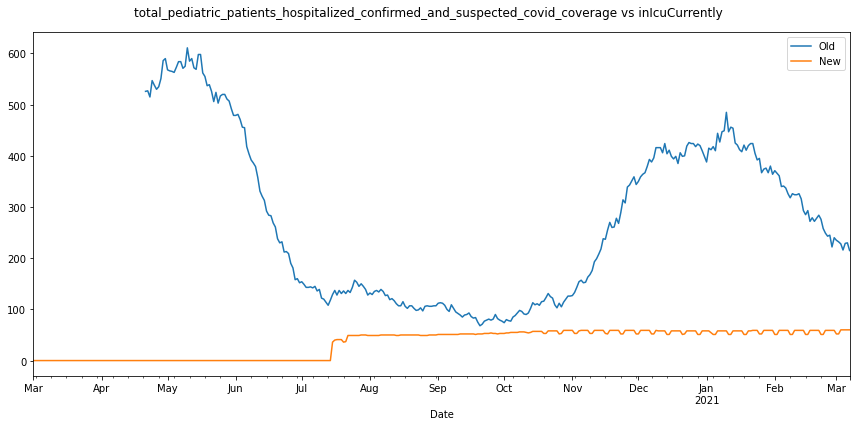




------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


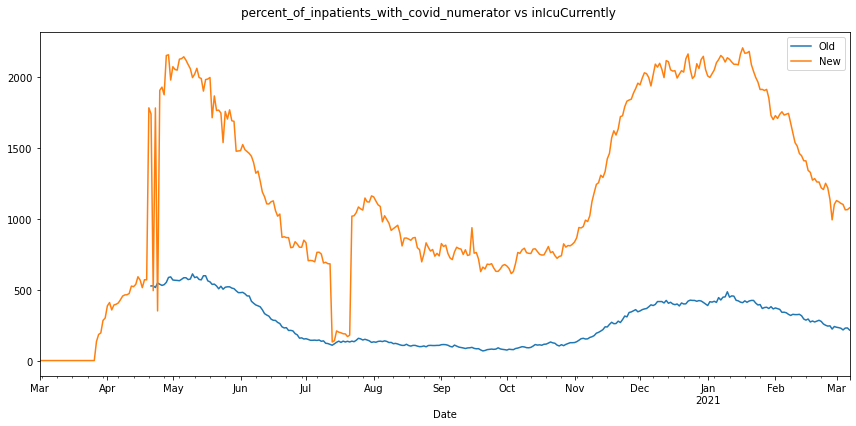




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid_coverage


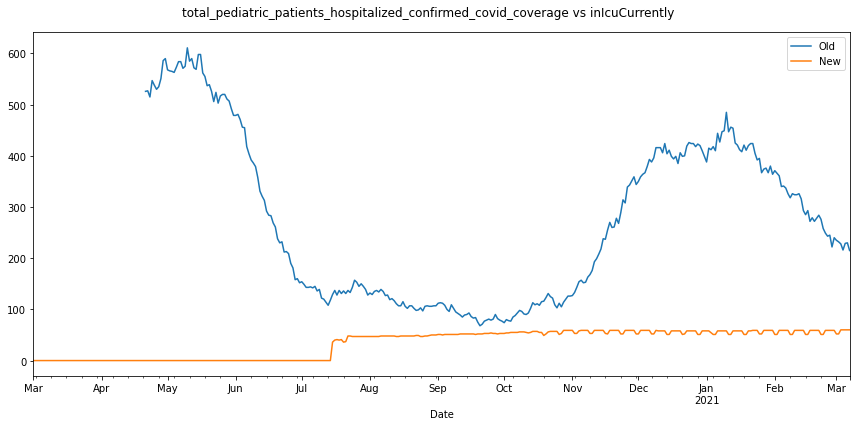




------------------------------------------------------------
adult_icu_bed_utilization_numerator


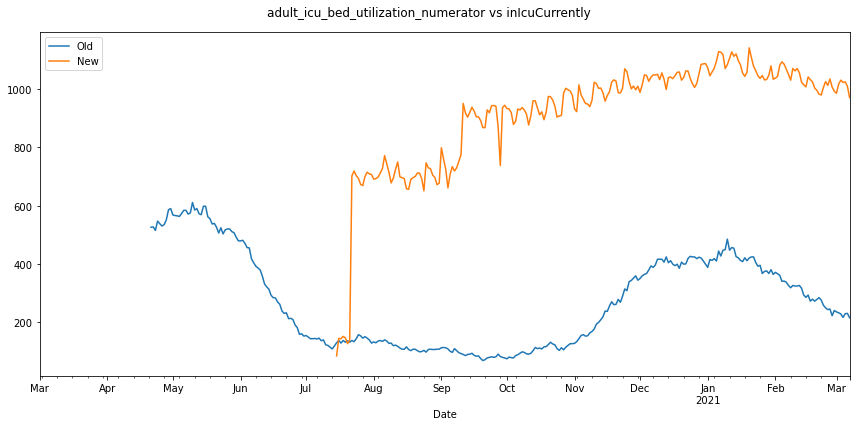




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid


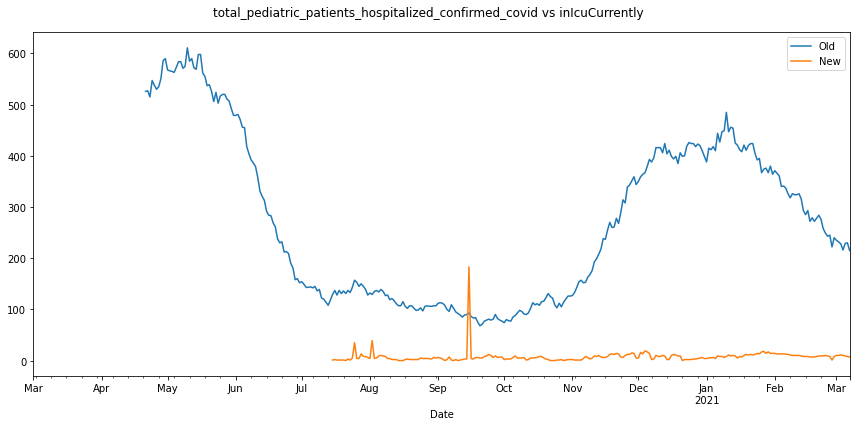




------------------------------------------------------------
inpatient_beds_used


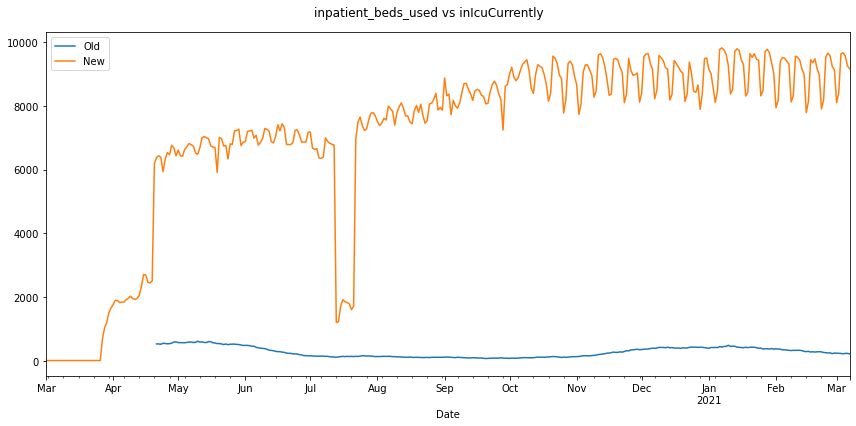




------------------------------------------------------------
inpatient_bed_covid_utilization_denominator


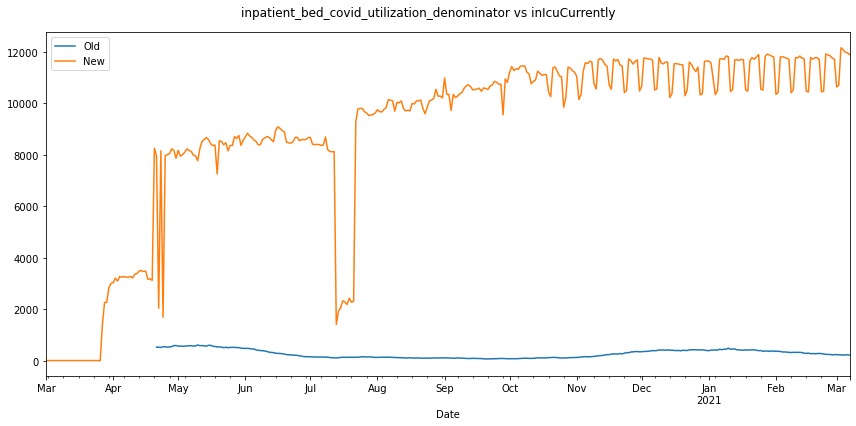




------------------------------------------------------------
deaths_covid


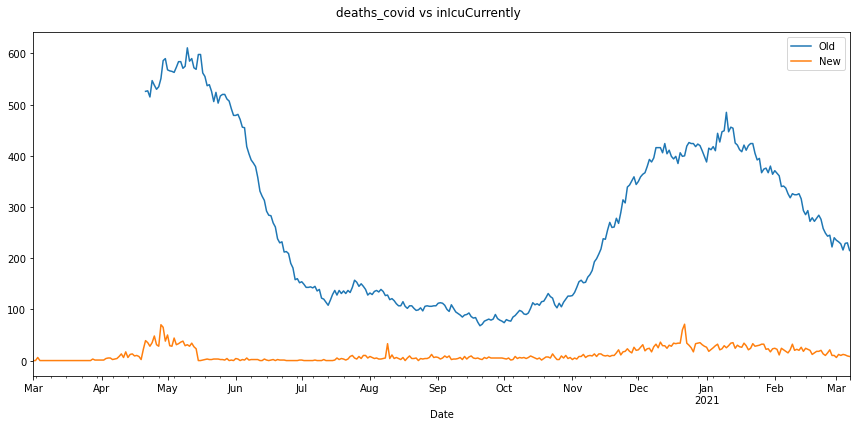




------------------------------------------------------------
percent_of_inpatients_with_covid


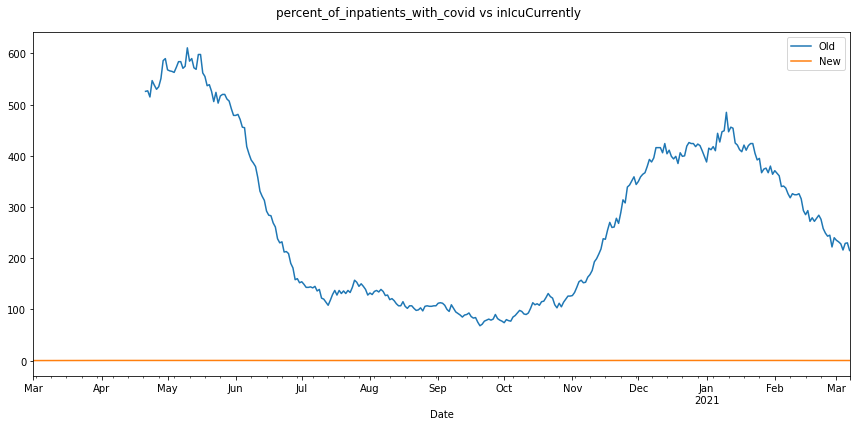




------------------------------------------------------------
inpatient_bed_covid_utilization_numerator


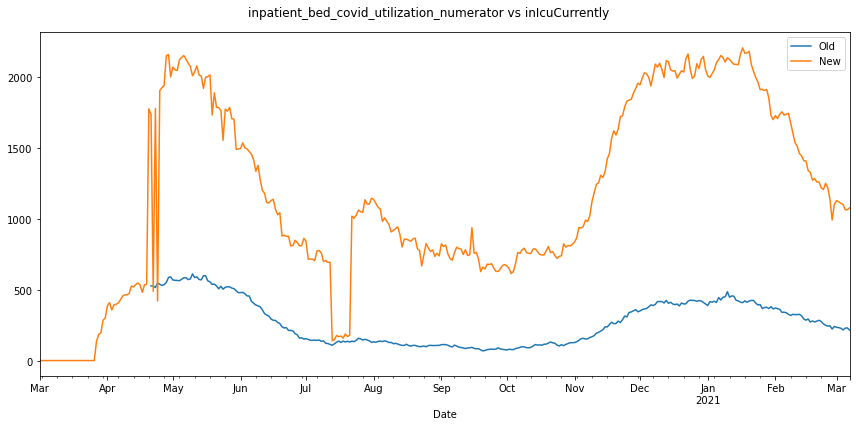




------------------------------------------------------------
deaths_covid_coverage


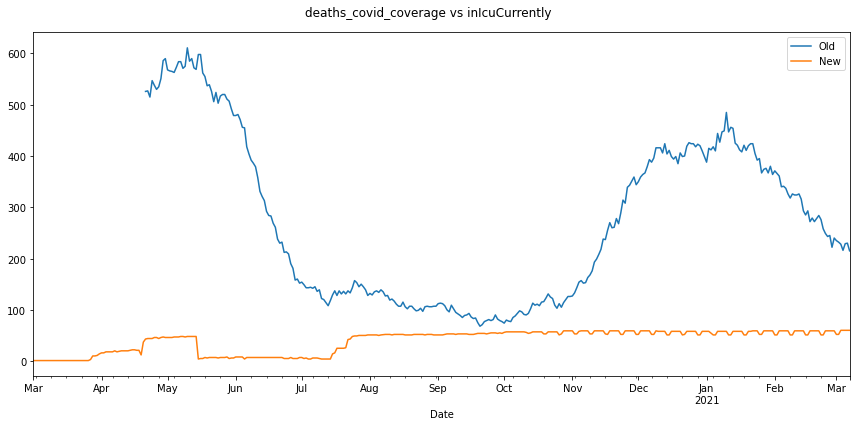




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid_coverage


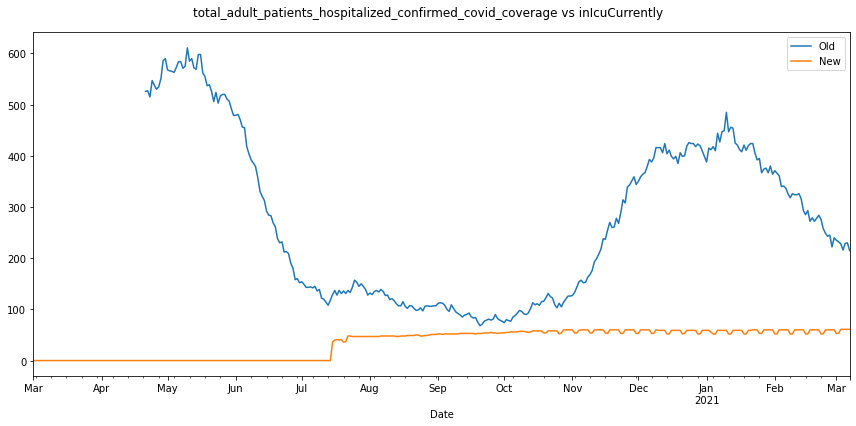




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid


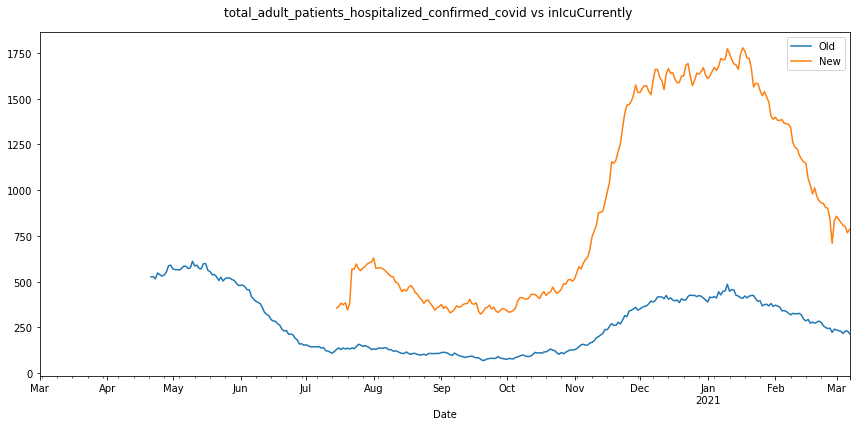




------------------------------------------------------------
inpatient_beds_coverage


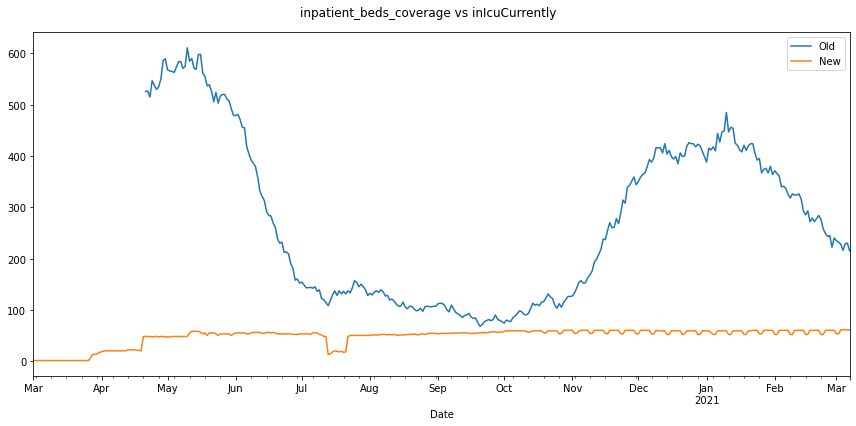




------------------------------------------------------------
inpatient_beds_utilization_denominator


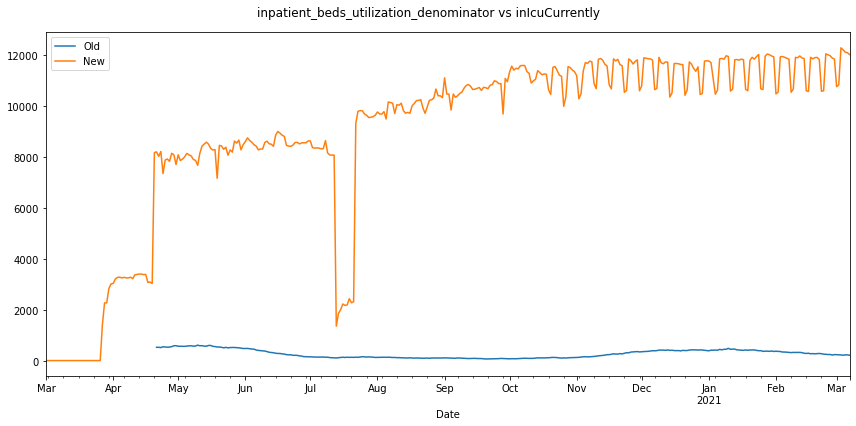




------------------------------------------------------------
inpatient_beds_utilization_coverage


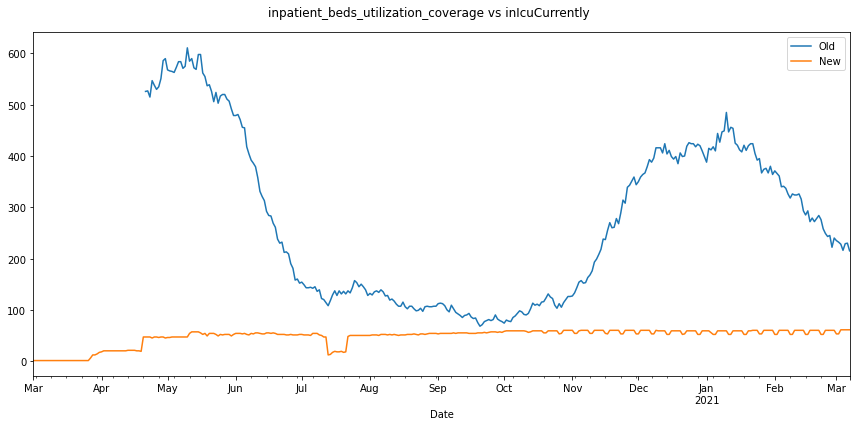




------------------------------------------------------------
staffed_adult_icu_bed_occupancy


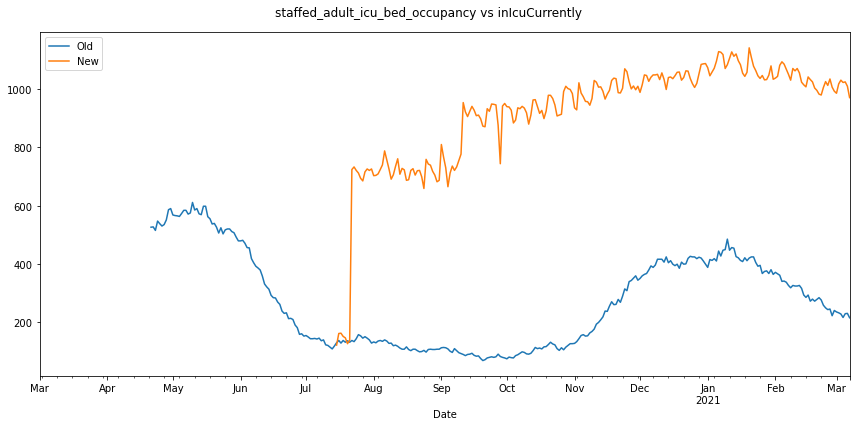




------------------------------------------------------------
inpatient_beds_used_coverage


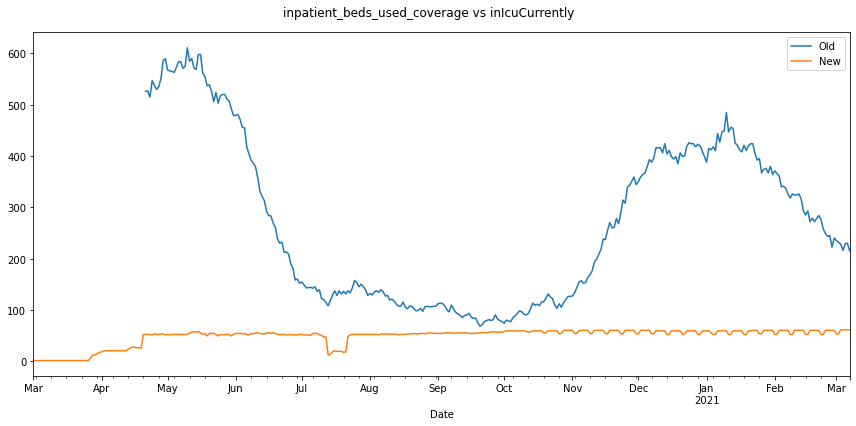




------------------------------------------------------------
adult_icu_bed_utilization_coverage


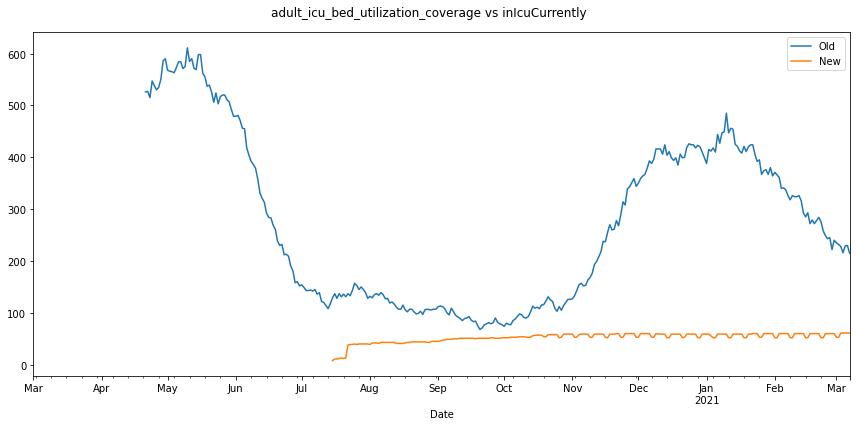




------------------------------------------------------------
inpatient_bed_covid_utilization


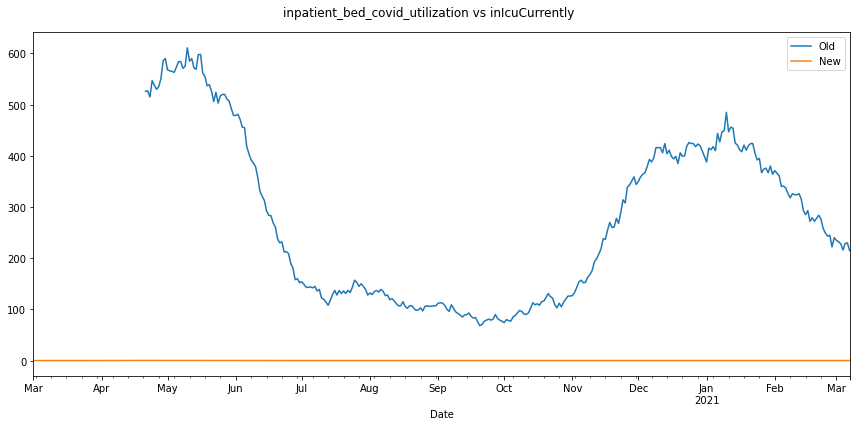




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid


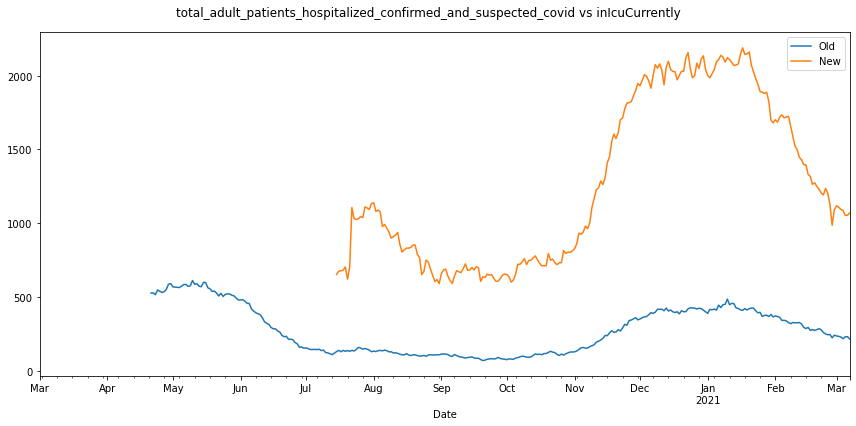




------------------------------------------------------------
adult_icu_bed_covid_utilization


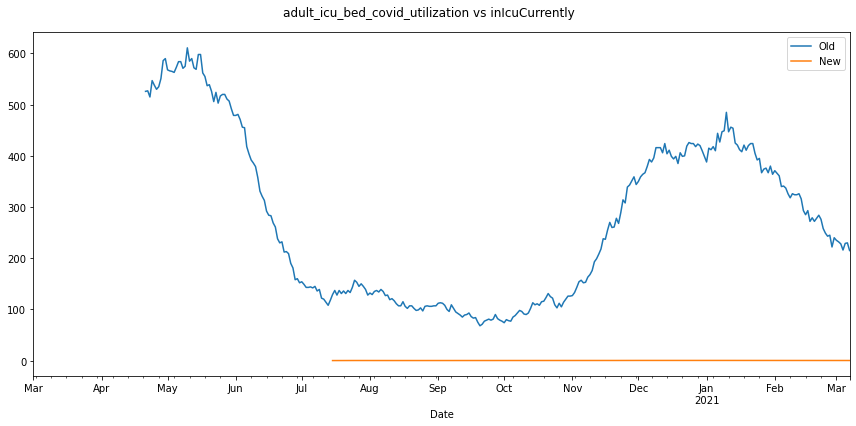




------------------------------------------------------------
percent_of_inpatients_with_covid_denominator


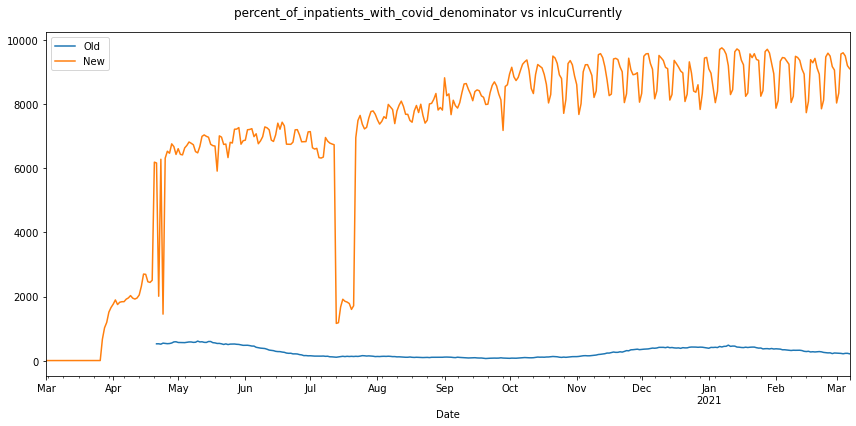

In [61]:
## Compare cols vs inIcuCurrently 
old_col = 'inIcuCurrently'

for col in new_md.columns:
    print('---'*20)
    print(f"{col}")
    fig, ax = plt.subplots()
    fig.suptitle(f"{col} vs {old_col}")
    old_md[old_col].plot(label='Old',ax=ax)
    new_md[col].plot(ax=ax,label='New')
    ax.legend()
    fig.tight_layout()
    plt.show()
    print('\n\n')
    

In [62]:
old_md[ 'hospitalizedCurrently']

date
2021-03-07    818.0
2021-03-06    830.0
2021-03-05    849.0
2021-03-04    856.0
2021-03-03    863.0
              ...  
2020-03-09      NaN
2020-03-08      NaN
2020-03-07      NaN
2020-03-06      NaN
2020-03-05      NaN
Name: hospitalizedCurrently, Length: 368, dtype: float64

In [69]:
# ## Compare cols vs inIcuCumulative 
# old_col = 'hospitalizedCurrently'


# for col in new_md.columns:
#     print('---'*20)
#     print(f"{col}")
#     fig, ax = plt.subplots()
#     fig.suptitle(f"{col} vs {old_col}")
#     old_md[old_col].plot(label='Old',ax=ax)
#     new_md[col].plot(ax=ax,label='New')
#     ax.legend()
#     fig.tight_layout()
#     plt.show()
#     print('\n\n')


In [64]:
# md[[c for c in md.columns if 'inpatient_beds' in c]].plot()

# BOOKMARK -  end of 08/15/21

In [ ]:
def compare_old_vs_new_cols(old_df,new_df,old_col = 'hospitalizedCurrently'):
    ## Compare cols vs inIcuCumulative 
    


    for col in new_df.columns:
        print('---'*20)
        print(f"{col}")
        fig, ax = plt.subplots()
        fig.suptitle(f"{col} vs {old_col}")
        old_df[old_col].plot(label='Old',ax=ax)
        new_df[col].plot(ax=ax,label='New')
        ax.legend()
        fig.tight_layout()
        plt.show()
        print('\n\n')
        

------------------------------------------------------------
Cases


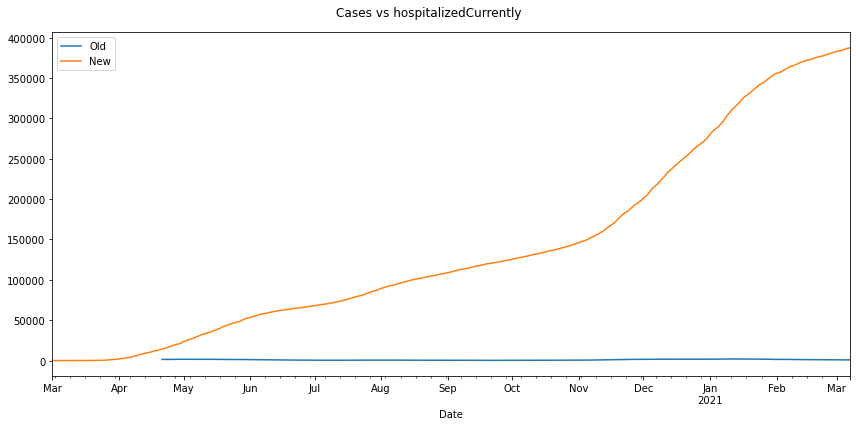




------------------------------------------------------------
Deaths


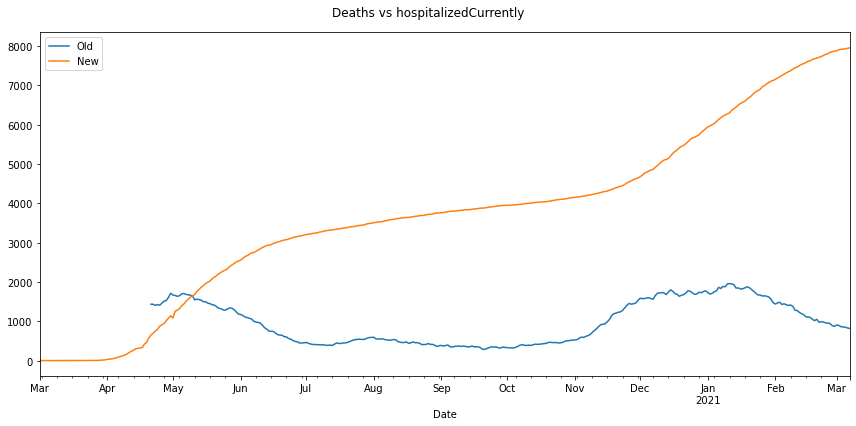




------------------------------------------------------------
inpatient_beds_utilization


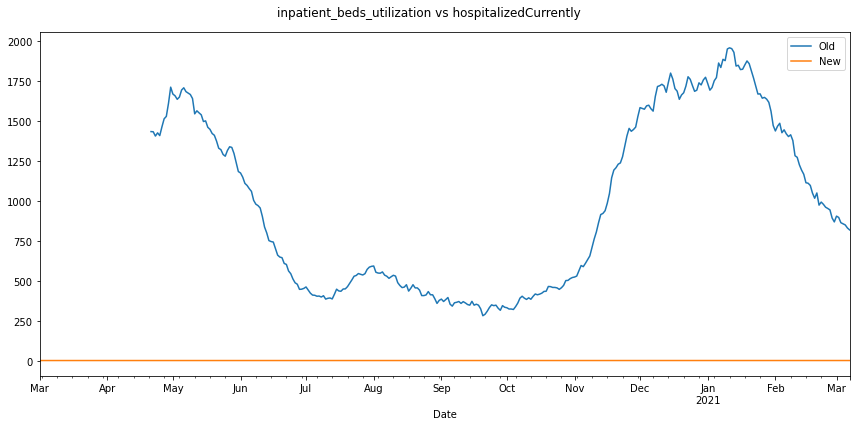




------------------------------------------------------------
total_staffed_adult_icu_beds_coverage


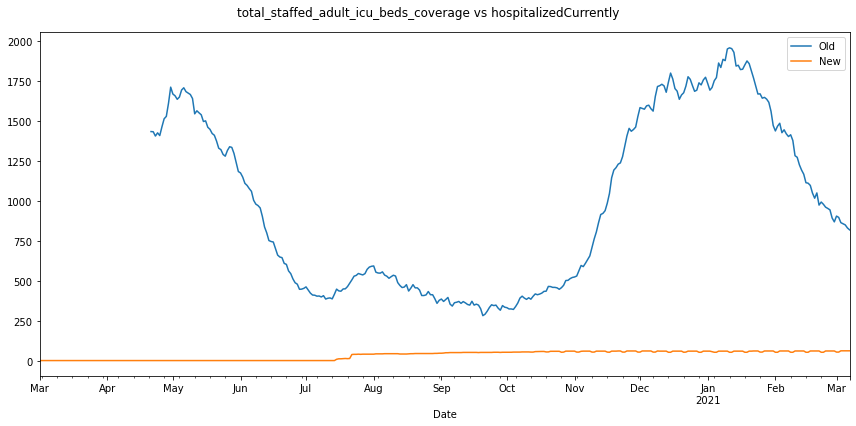




------------------------------------------------------------
adult_icu_bed_covid_utilization_coverage


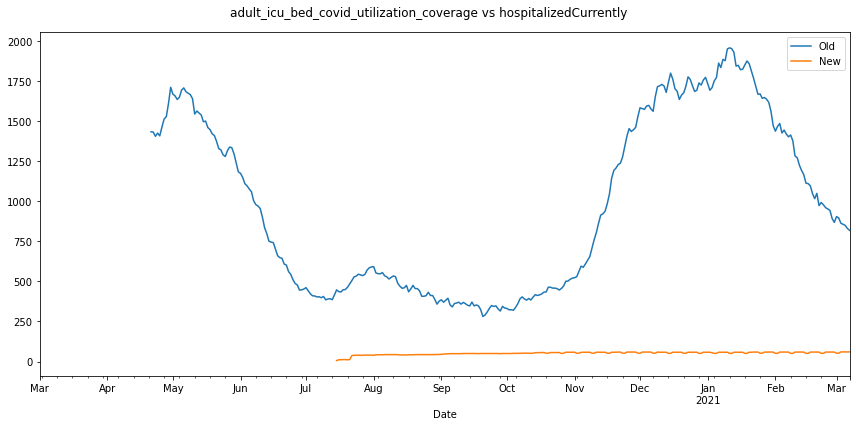




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage


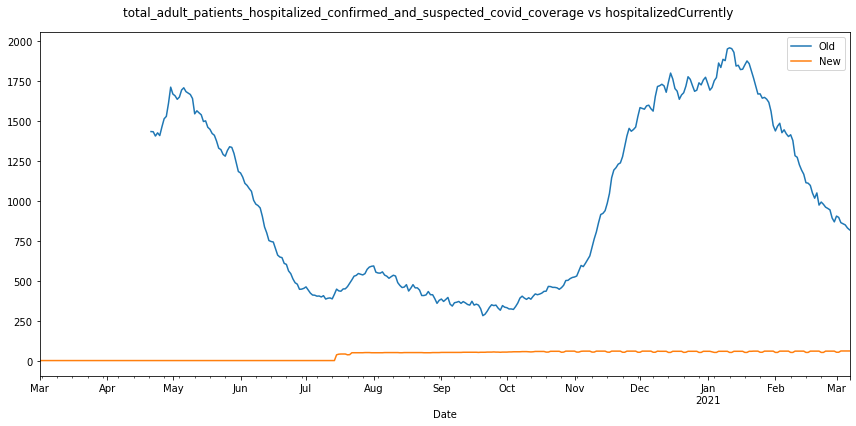




------------------------------------------------------------
percent_of_inpatients_with_covid_coverage


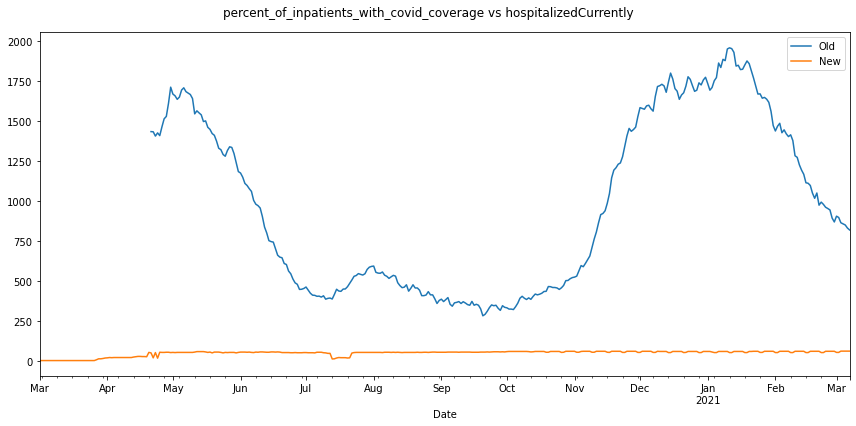




------------------------------------------------------------
staffed_adult_icu_bed_occupancy_coverage


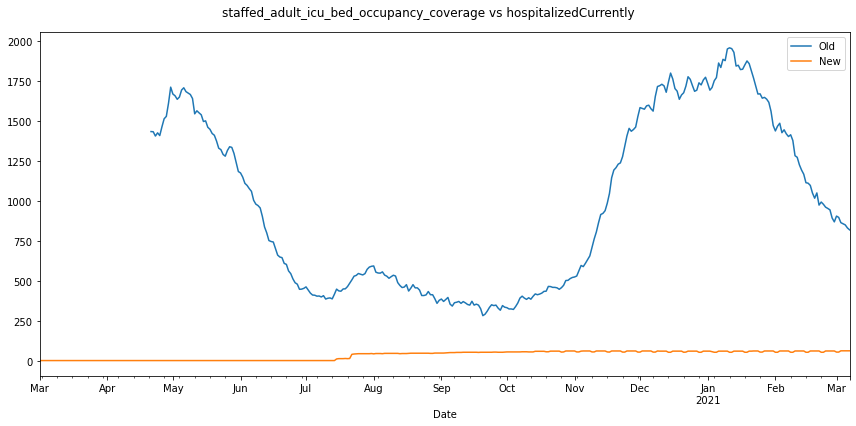




------------------------------------------------------------
inpatient_beds_used_covid_coverage


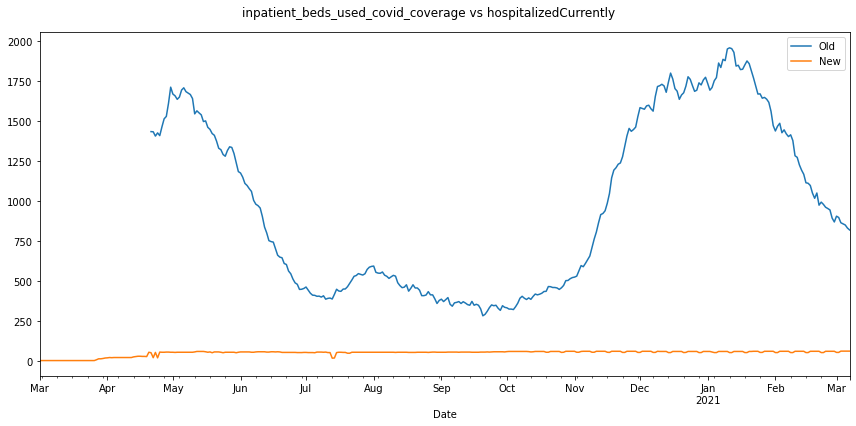




------------------------------------------------------------
inpatient_beds_utilization_numerator


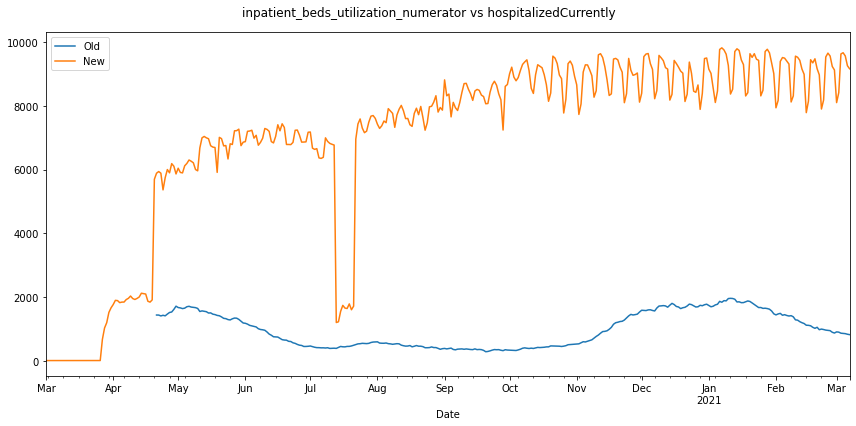




------------------------------------------------------------
inpatient_beds_used_covid


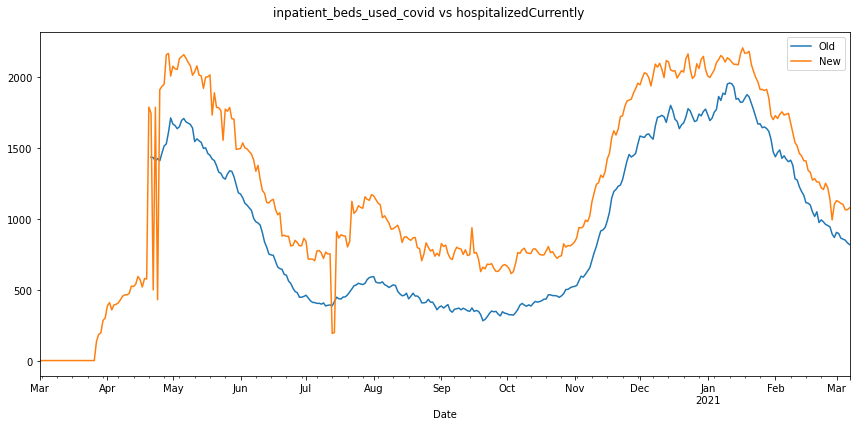




------------------------------------------------------------
total_staffed_adult_icu_beds


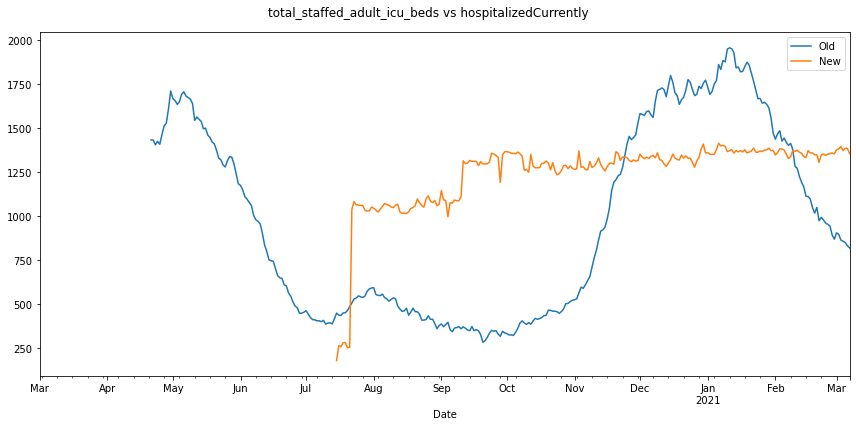




------------------------------------------------------------
inpatient_bed_covid_utilization_coverage


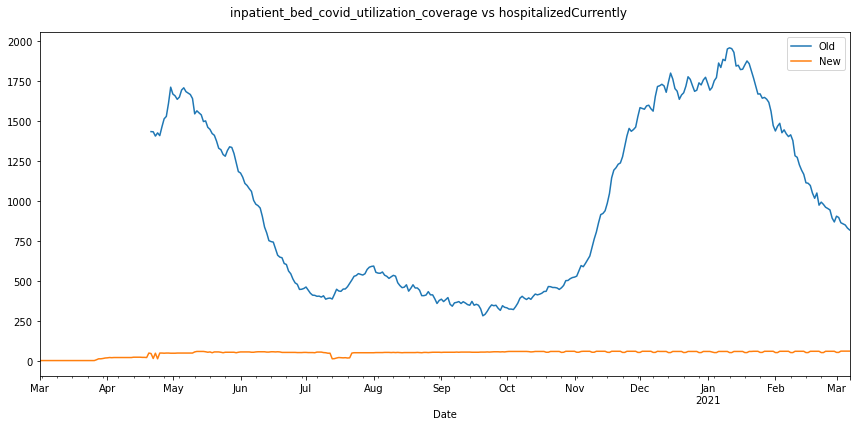




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid


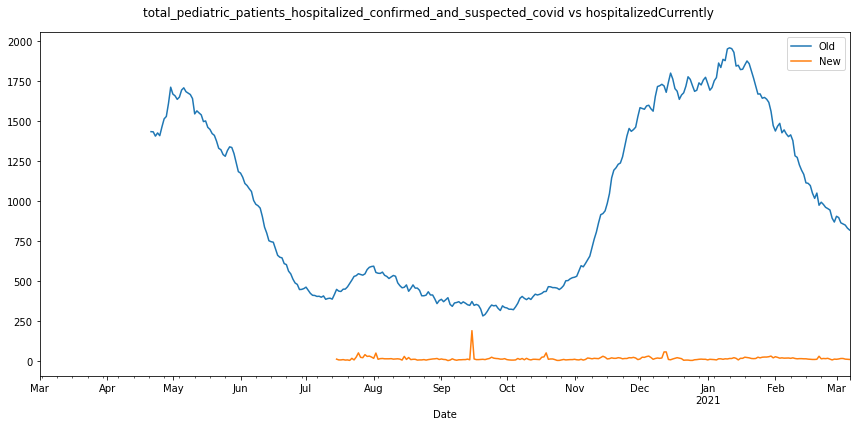




------------------------------------------------------------
inpatient_beds


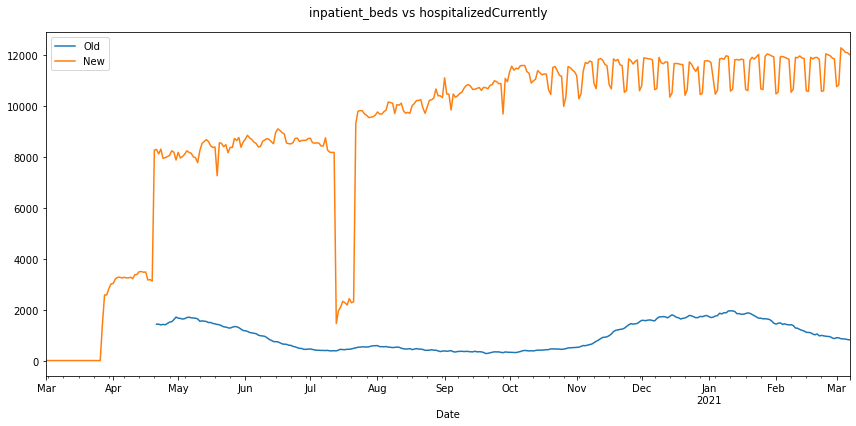




------------------------------------------------------------
adult_icu_bed_utilization_denominator


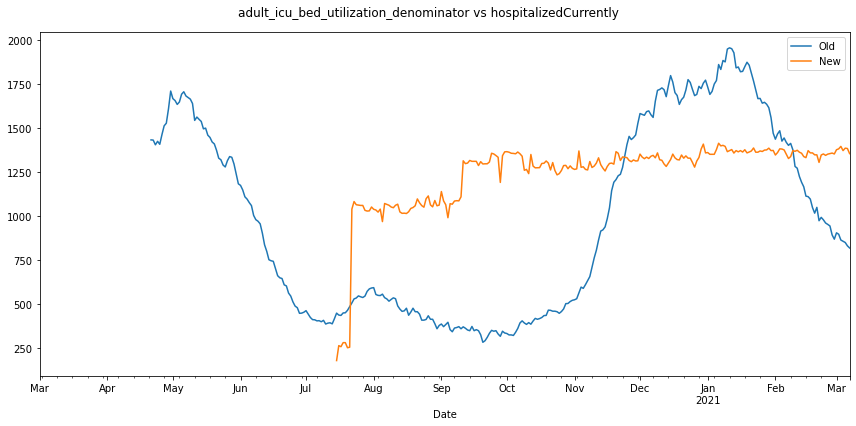




------------------------------------------------------------
adult_icu_bed_covid_utilization_numerator


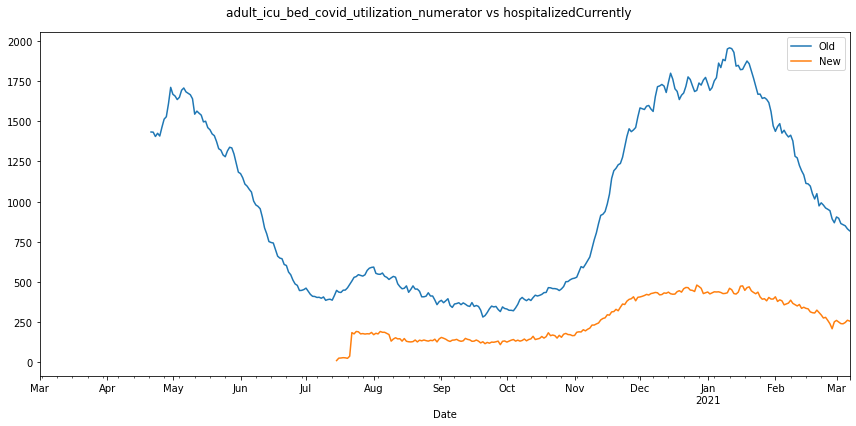




------------------------------------------------------------
adult_icu_bed_covid_utilization_denominator


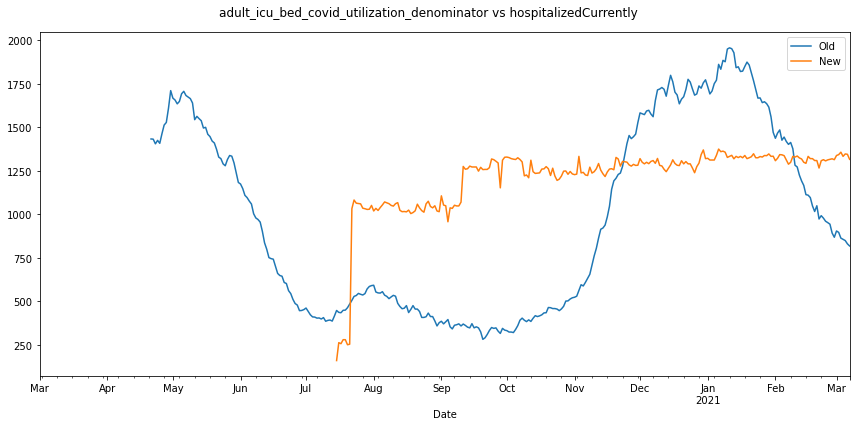




------------------------------------------------------------
adult_icu_bed_utilization


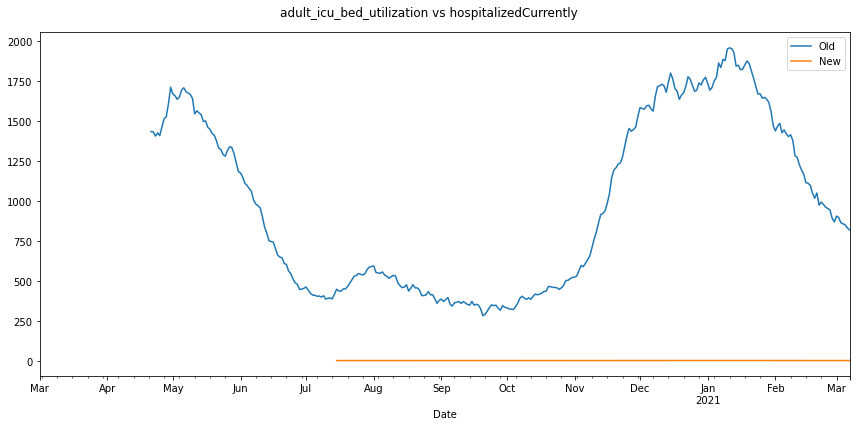




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage


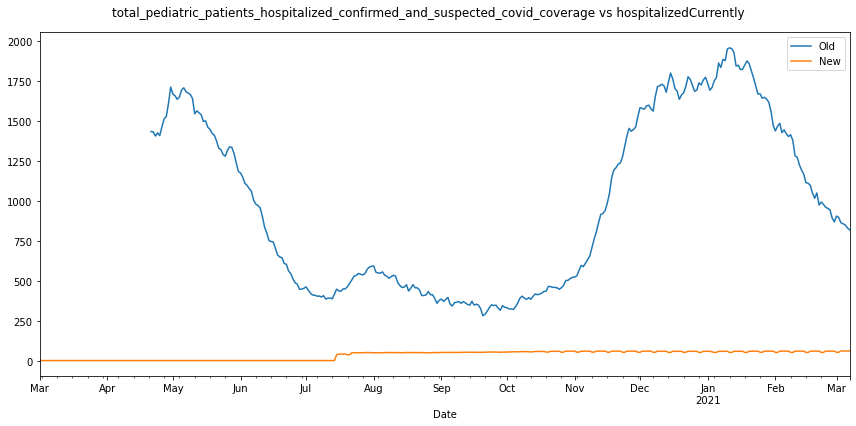




------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


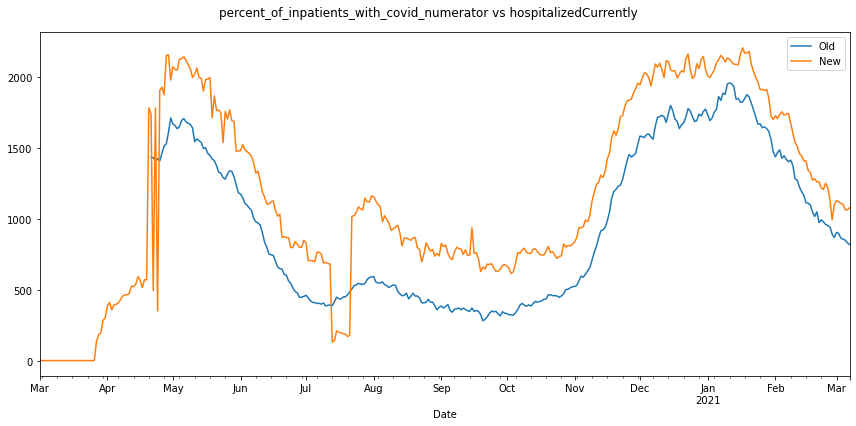




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid_coverage


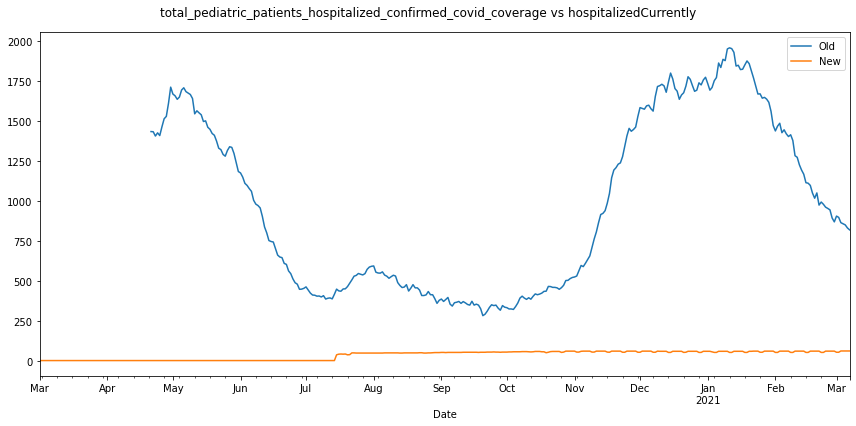




------------------------------------------------------------
adult_icu_bed_utilization_numerator


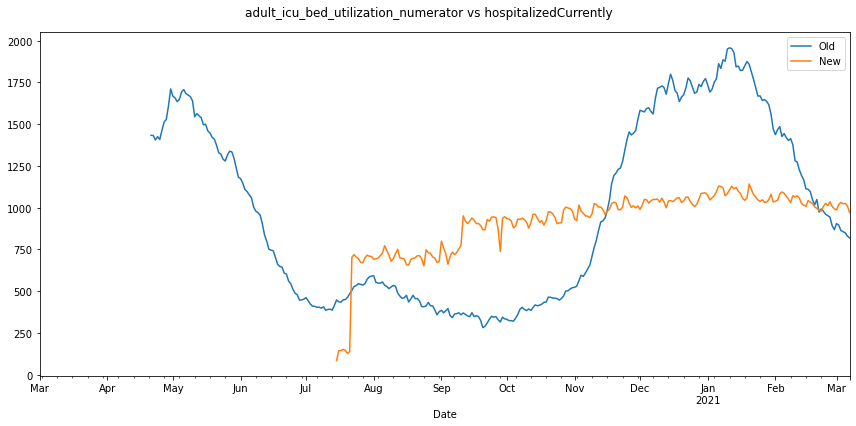




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid


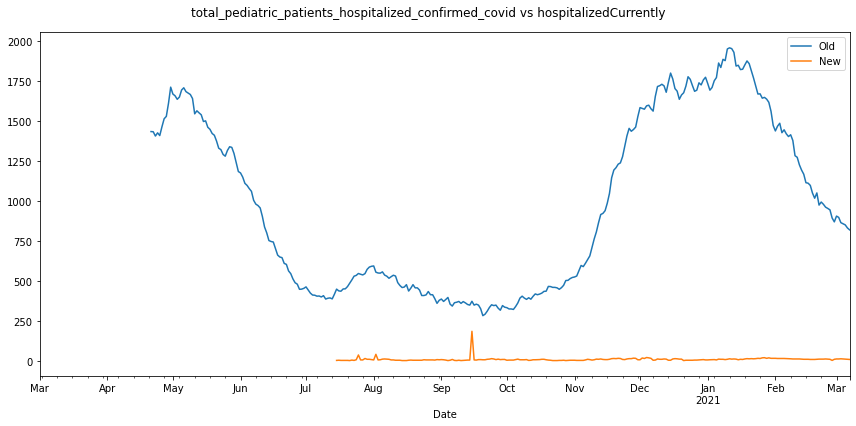




------------------------------------------------------------
inpatient_beds_used


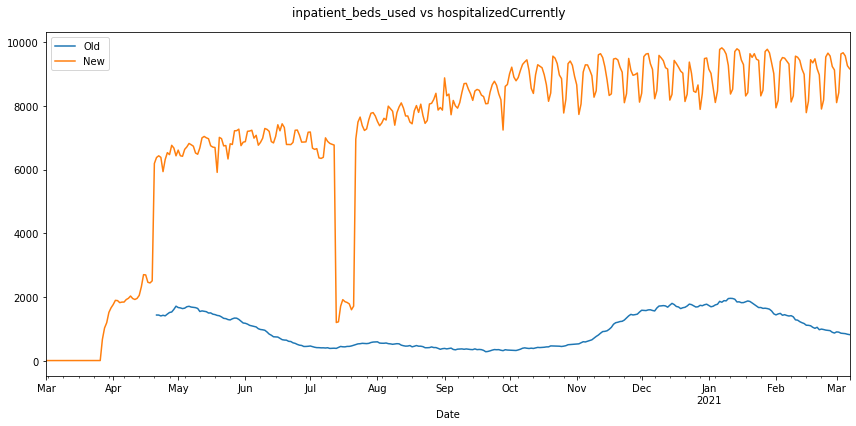




------------------------------------------------------------
inpatient_bed_covid_utilization_denominator


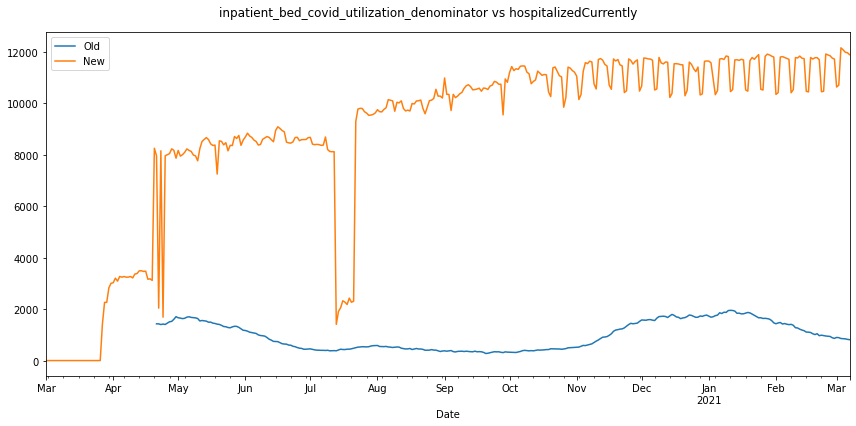




------------------------------------------------------------
deaths_covid


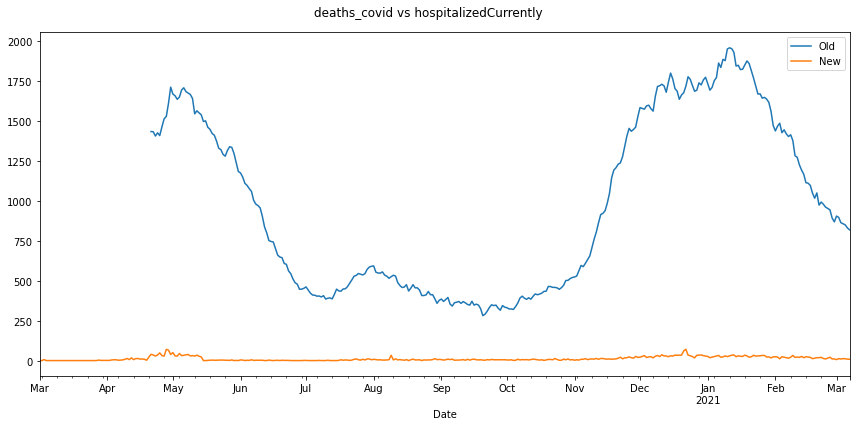




------------------------------------------------------------
percent_of_inpatients_with_covid


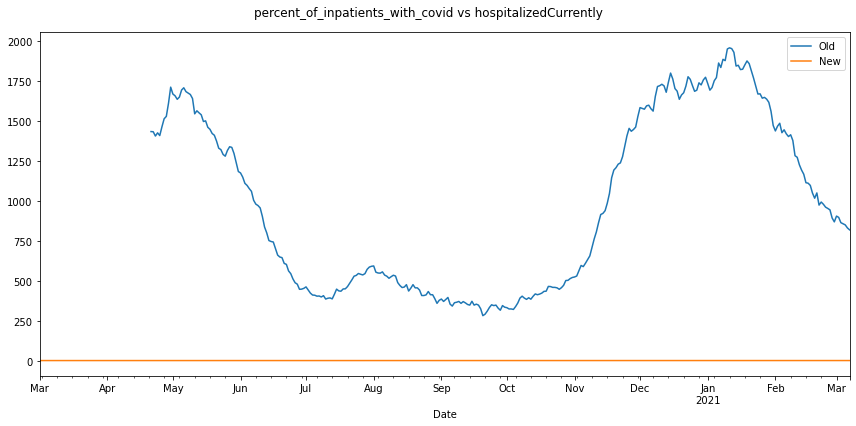




------------------------------------------------------------
inpatient_bed_covid_utilization_numerator


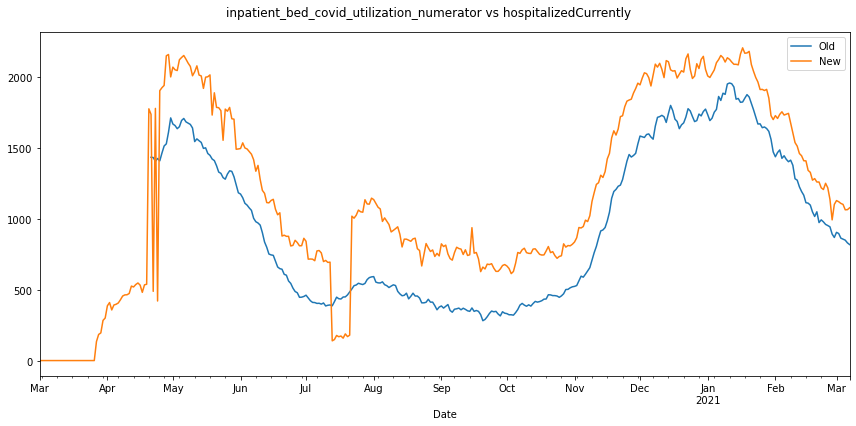




------------------------------------------------------------
deaths_covid_coverage


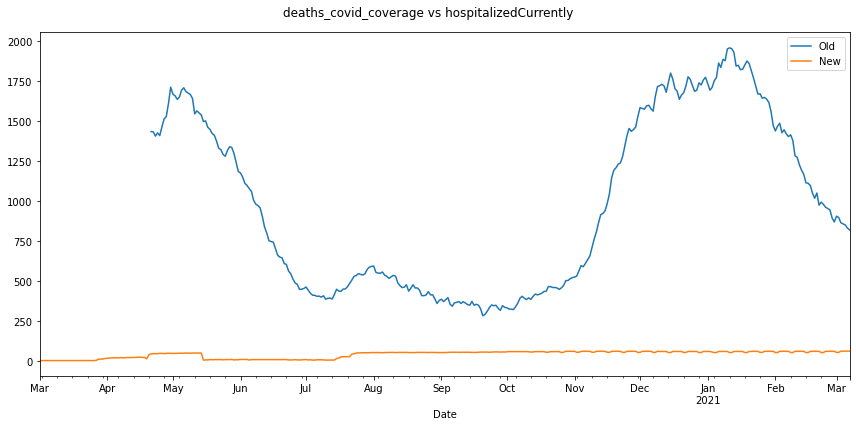




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid_coverage


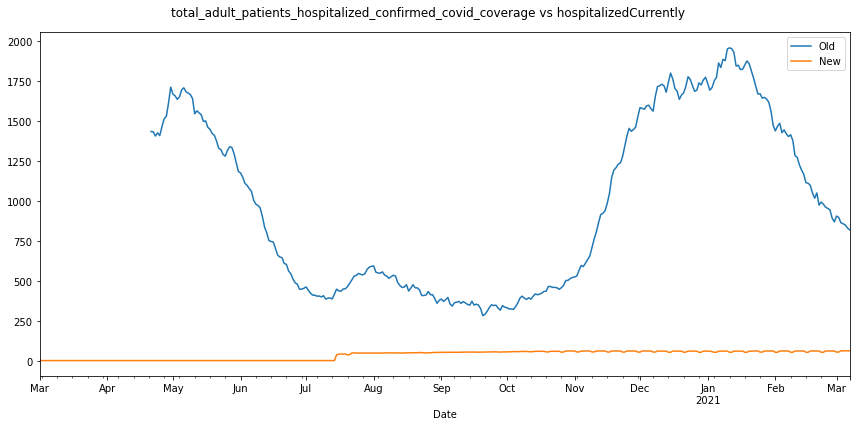




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid


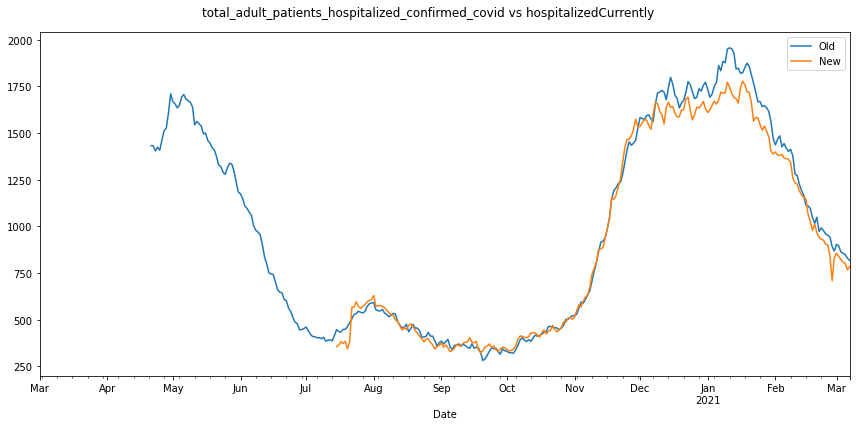




------------------------------------------------------------
inpatient_beds_coverage


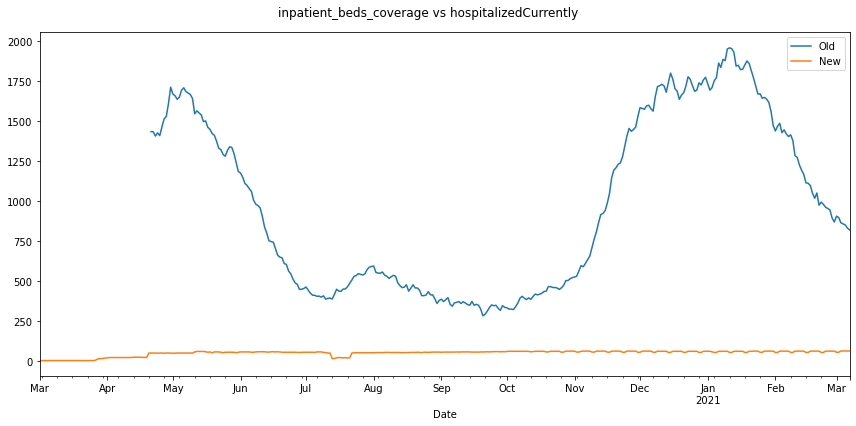




------------------------------------------------------------
inpatient_beds_utilization_denominator


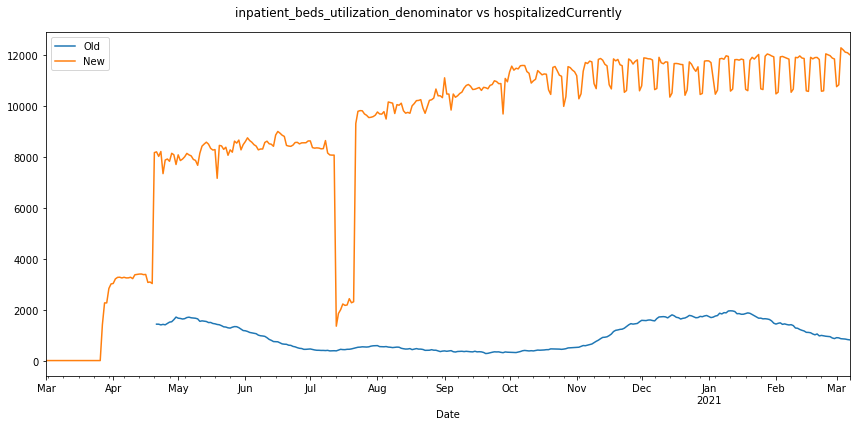




------------------------------------------------------------
inpatient_beds_utilization_coverage


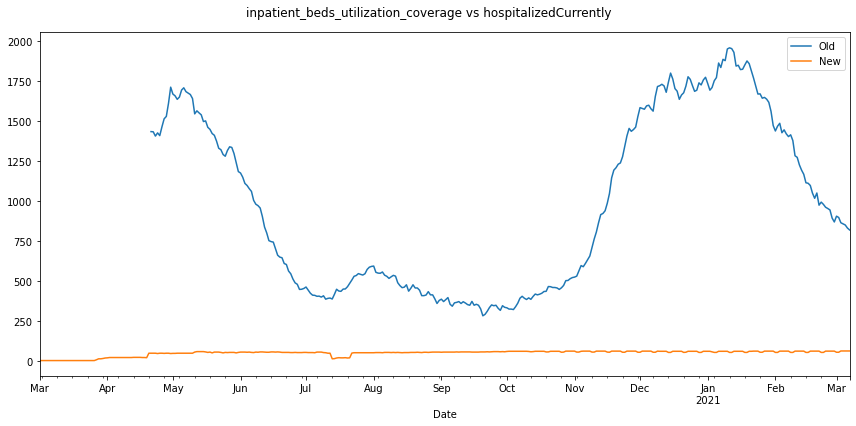




------------------------------------------------------------
staffed_adult_icu_bed_occupancy


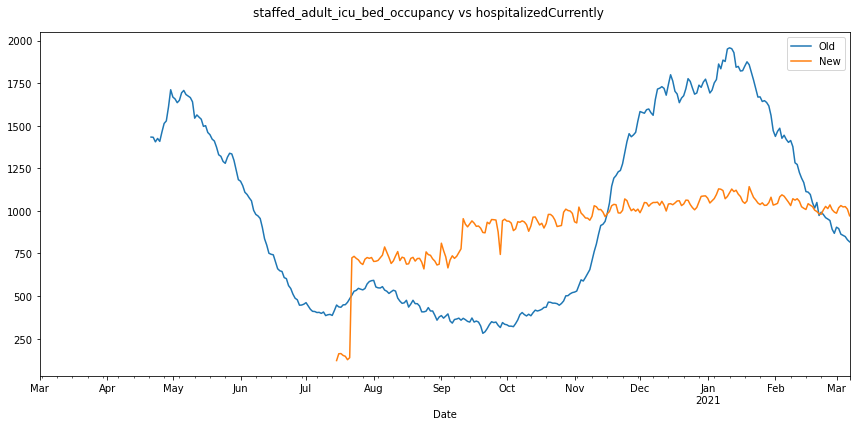




------------------------------------------------------------
inpatient_beds_used_coverage


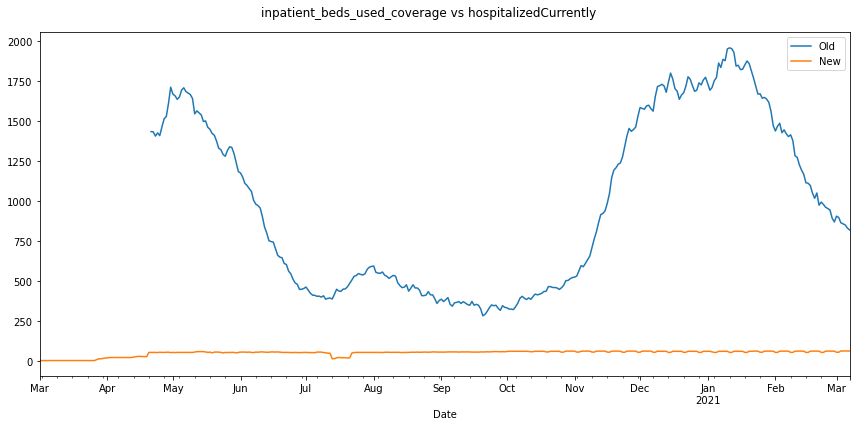




------------------------------------------------------------
adult_icu_bed_utilization_coverage


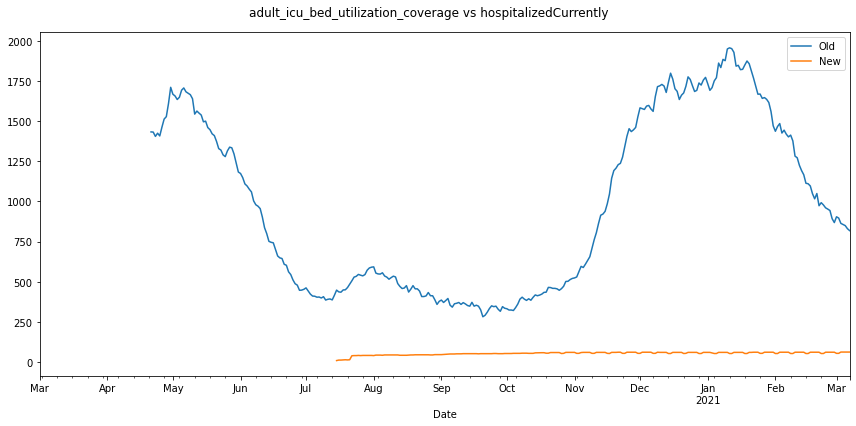




------------------------------------------------------------
inpatient_bed_covid_utilization


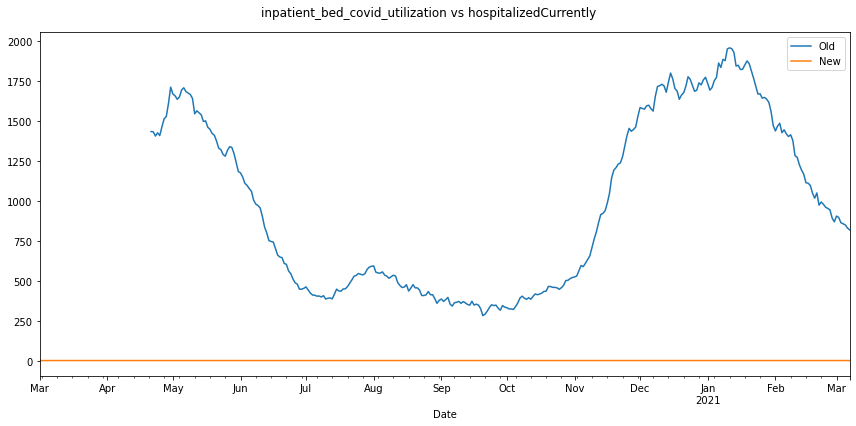




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid


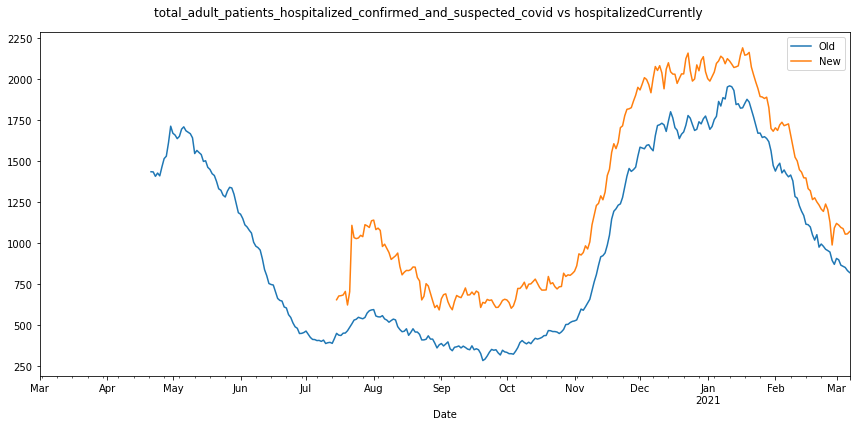




------------------------------------------------------------
adult_icu_bed_covid_utilization


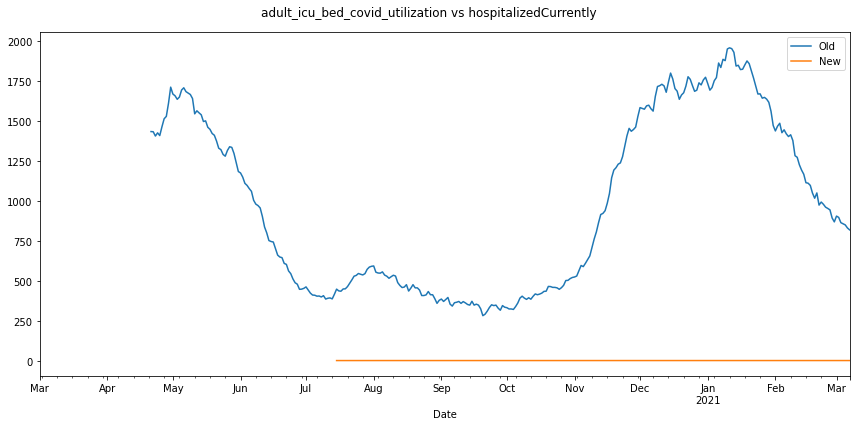




------------------------------------------------------------
percent_of_inpatients_with_covid_denominator


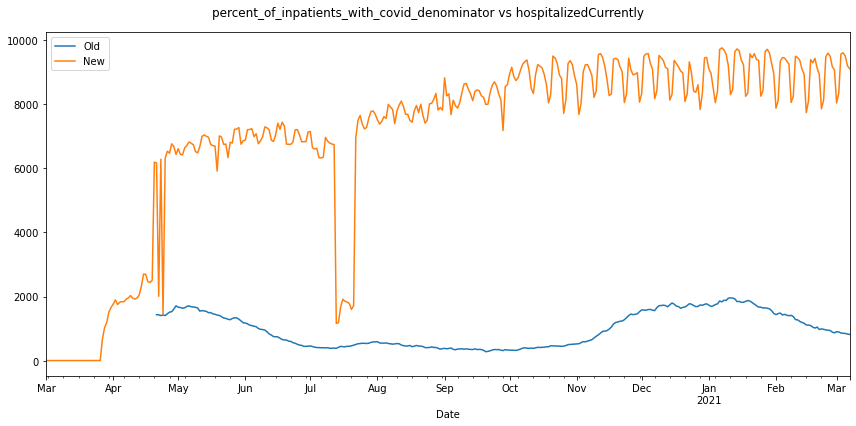

In [70]:
compare_old_vs_new_cols(old_md,new_md,old_col='hospitalizedCurrently')

------------------------------------------------------------
Cases


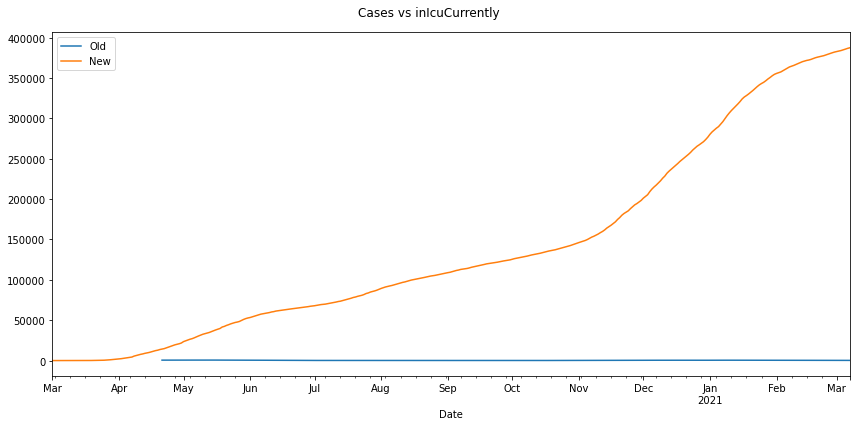




------------------------------------------------------------
Deaths


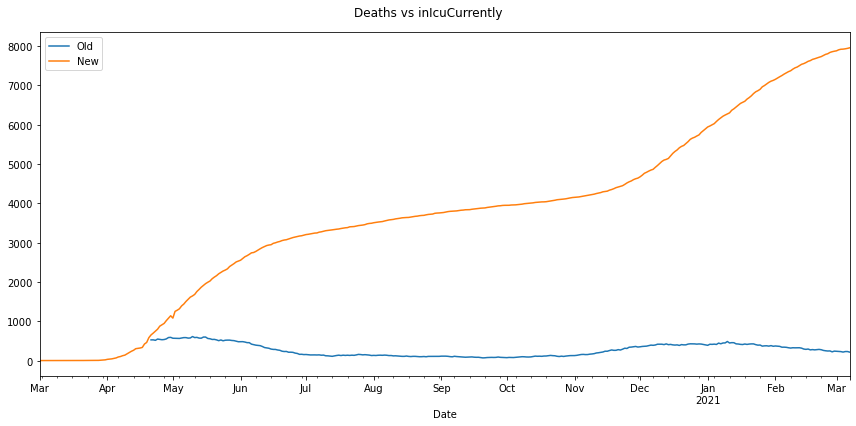




------------------------------------------------------------
inpatient_beds_utilization


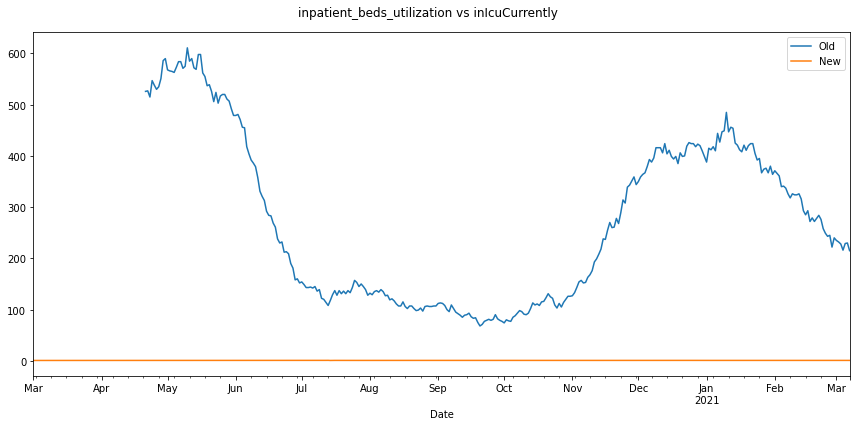




------------------------------------------------------------
total_staffed_adult_icu_beds_coverage


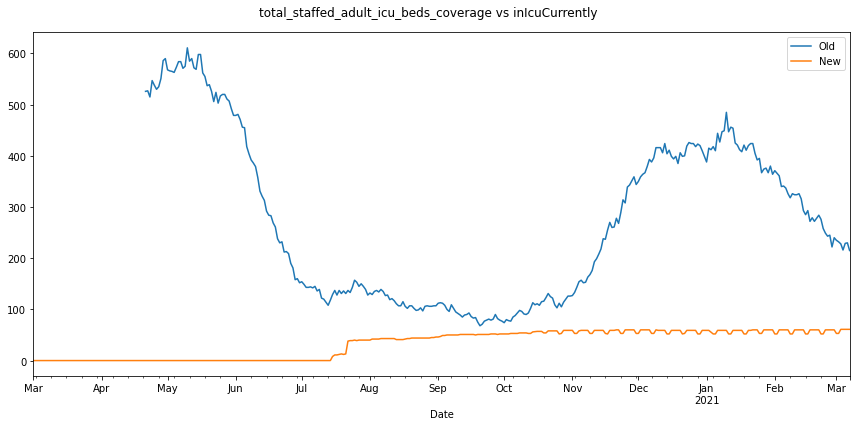




------------------------------------------------------------
adult_icu_bed_covid_utilization_coverage


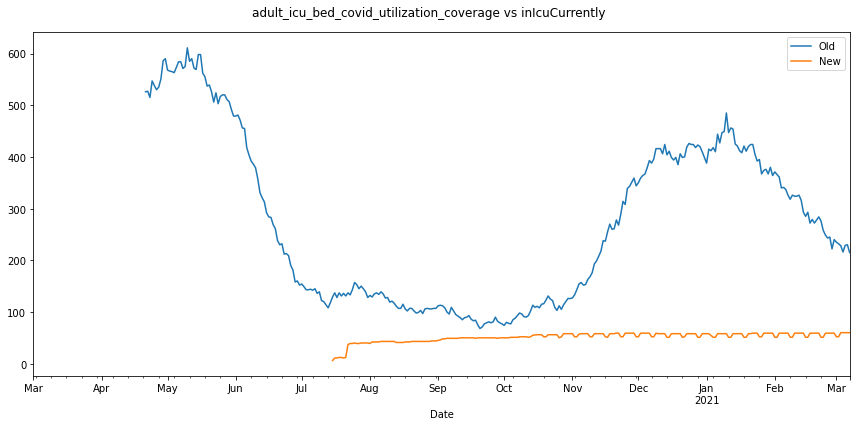




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage


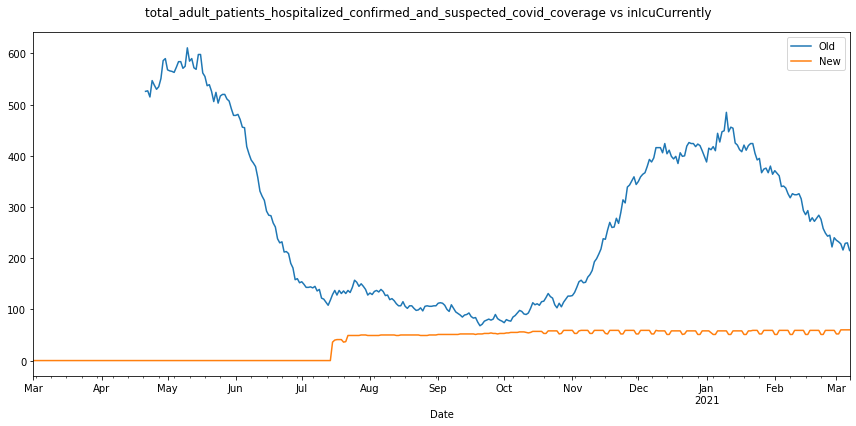




------------------------------------------------------------
percent_of_inpatients_with_covid_coverage


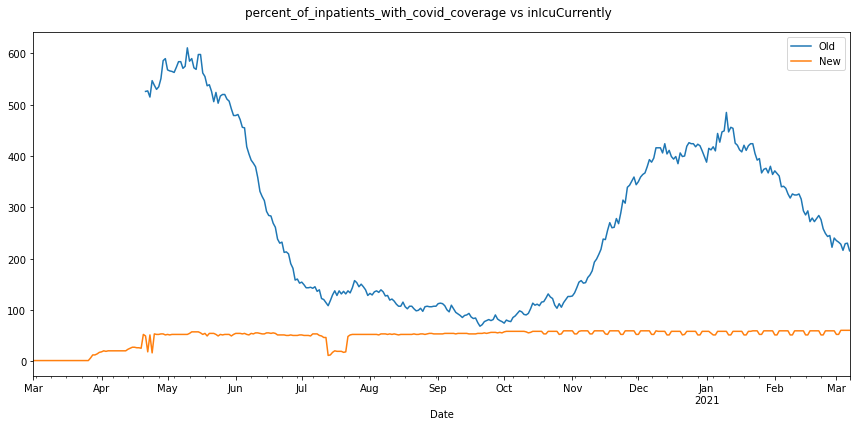




------------------------------------------------------------
staffed_adult_icu_bed_occupancy_coverage


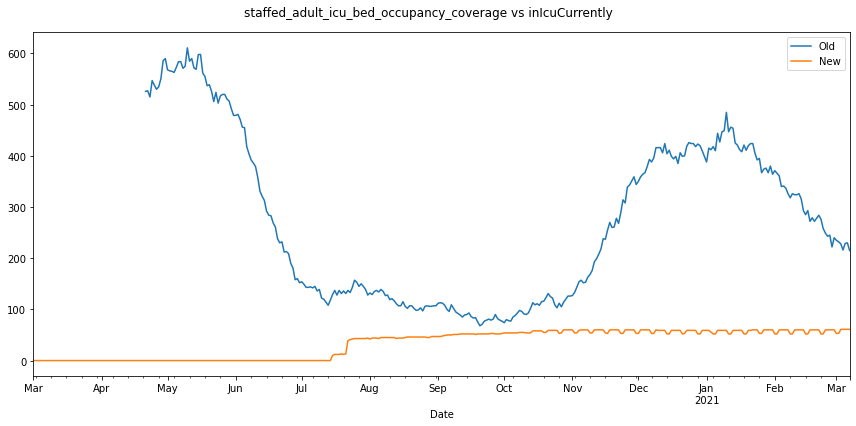




------------------------------------------------------------
inpatient_beds_used_covid_coverage


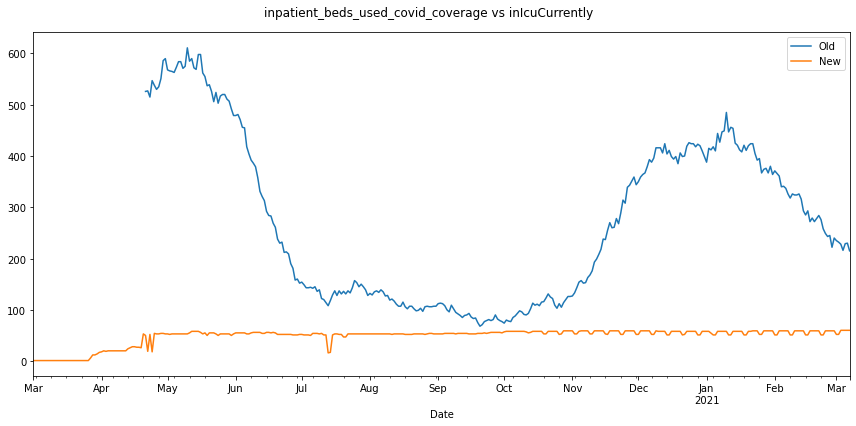




------------------------------------------------------------
inpatient_beds_utilization_numerator


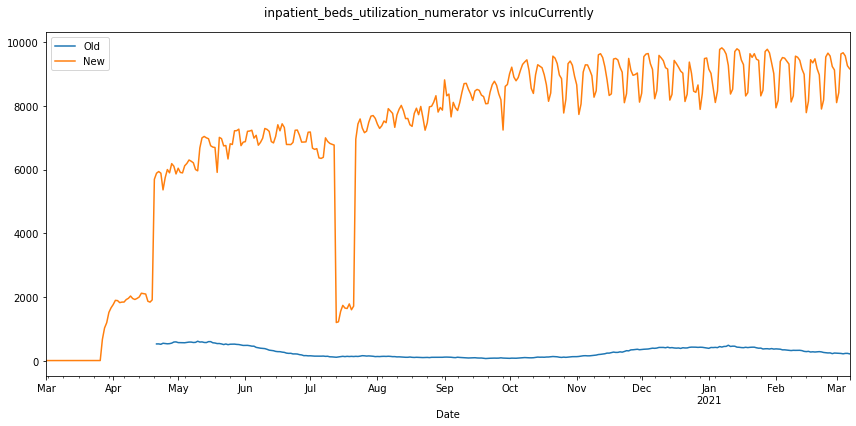




------------------------------------------------------------
inpatient_beds_used_covid


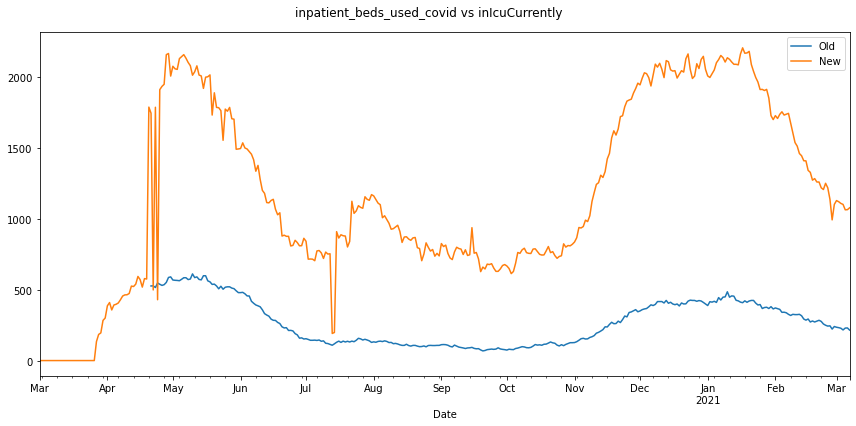




------------------------------------------------------------
total_staffed_adult_icu_beds


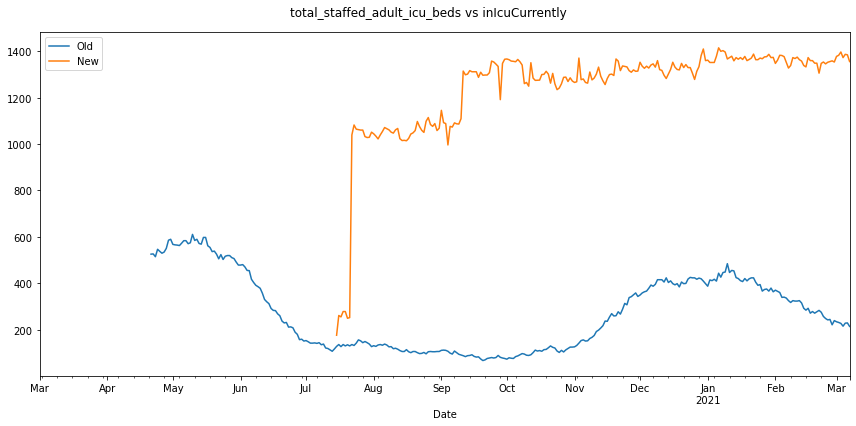




------------------------------------------------------------
inpatient_bed_covid_utilization_coverage


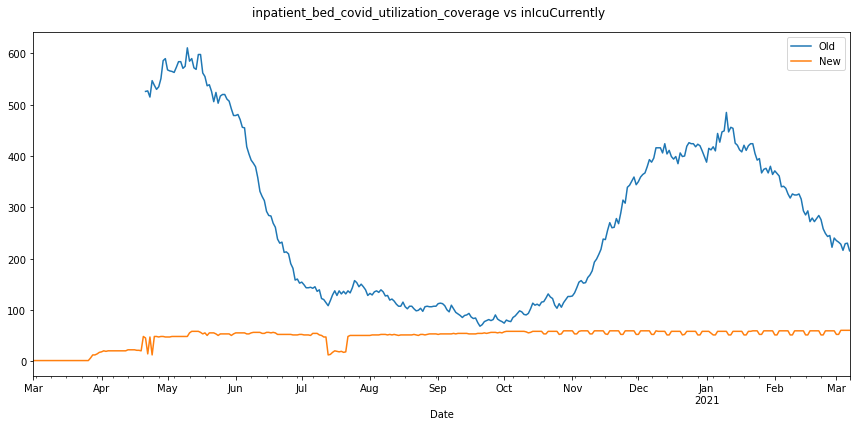




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid


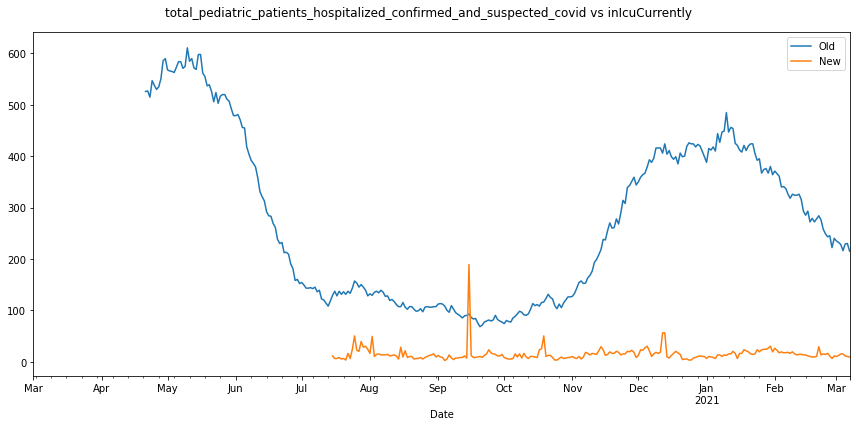




------------------------------------------------------------
inpatient_beds


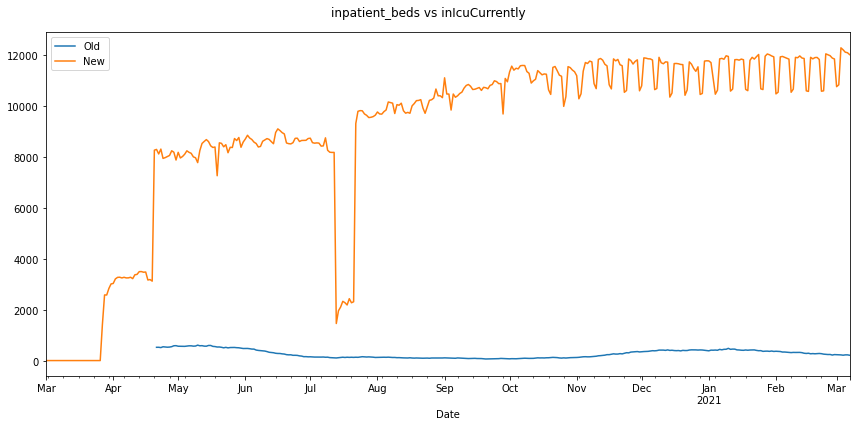




------------------------------------------------------------
adult_icu_bed_utilization_denominator


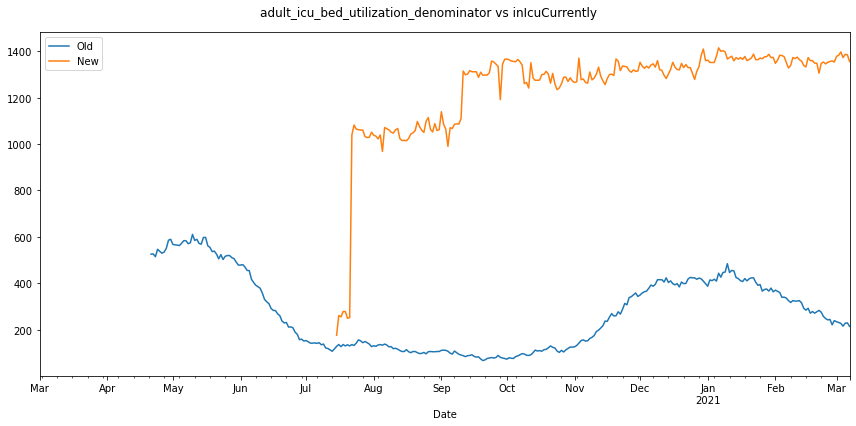




------------------------------------------------------------
adult_icu_bed_covid_utilization_numerator


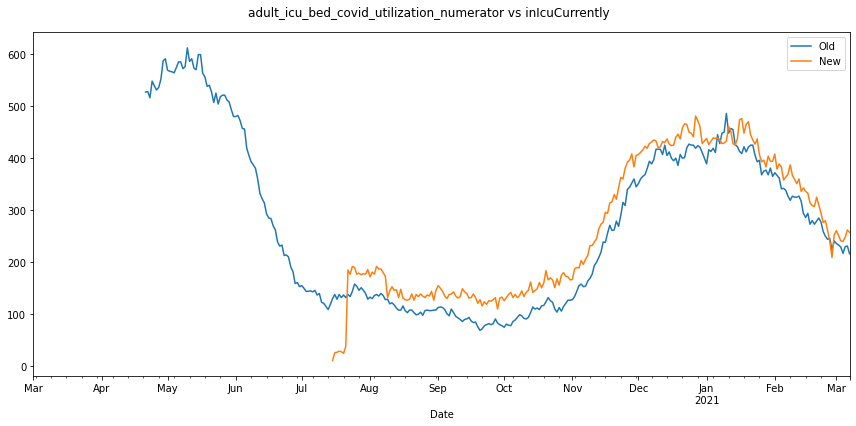




------------------------------------------------------------
adult_icu_bed_covid_utilization_denominator


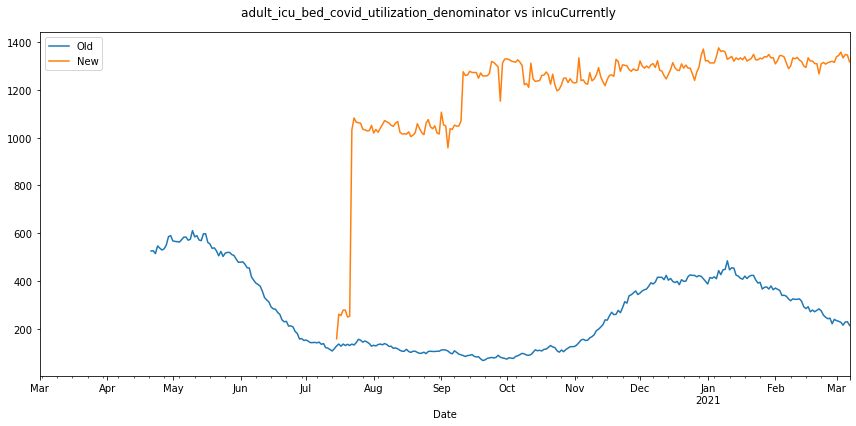




------------------------------------------------------------
adult_icu_bed_utilization


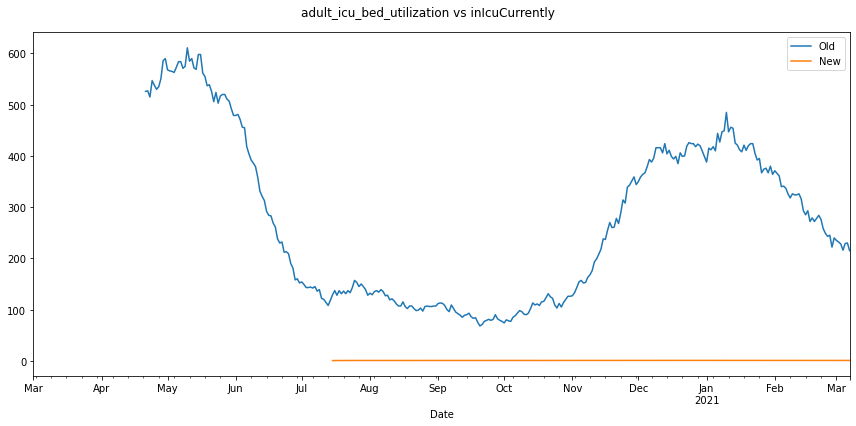




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage


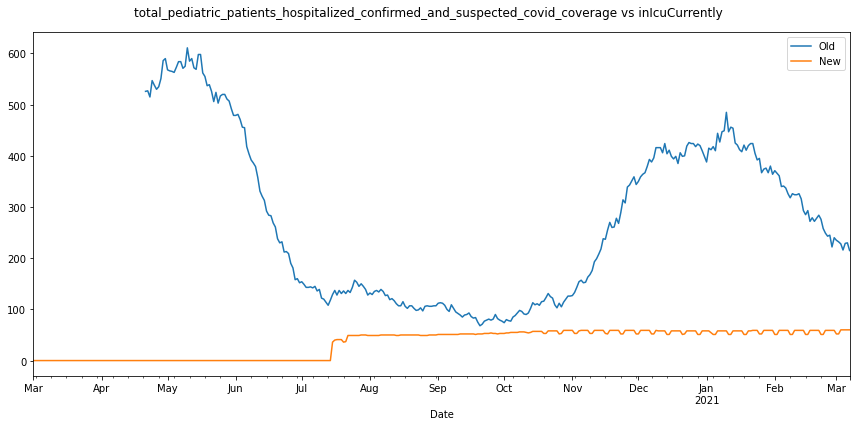




------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


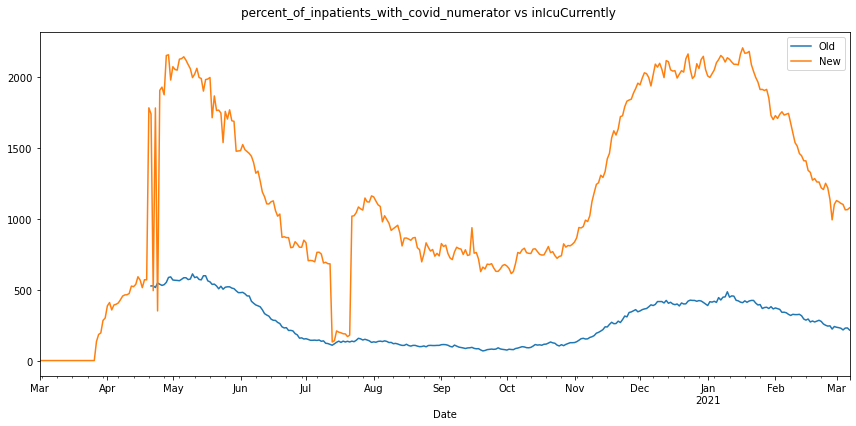




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid_coverage


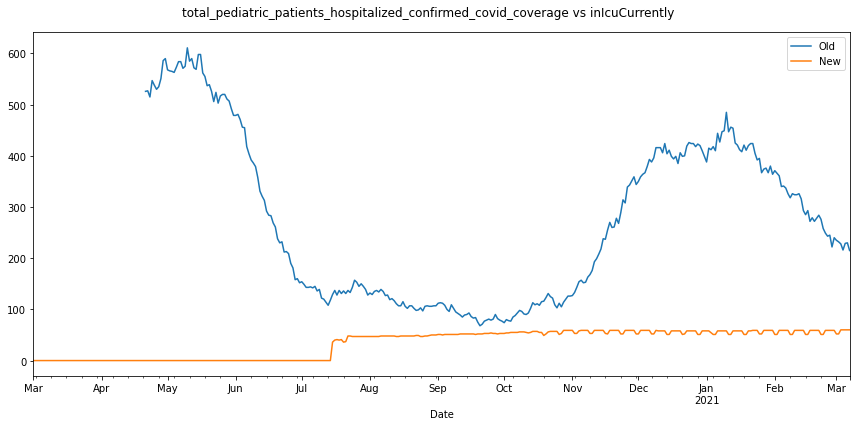




------------------------------------------------------------
adult_icu_bed_utilization_numerator


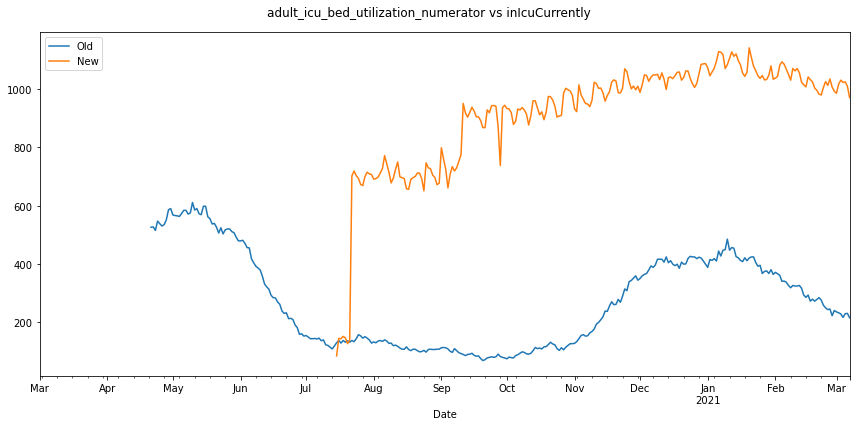




------------------------------------------------------------
total_pediatric_patients_hospitalized_confirmed_covid


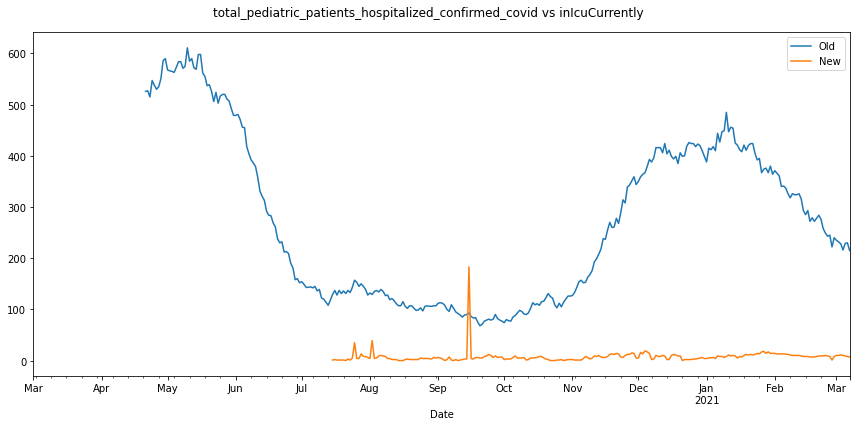




------------------------------------------------------------
inpatient_beds_used


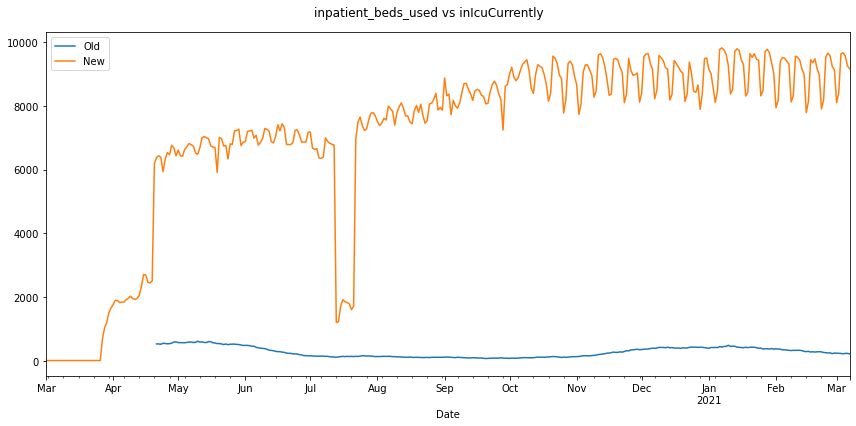




------------------------------------------------------------
inpatient_bed_covid_utilization_denominator


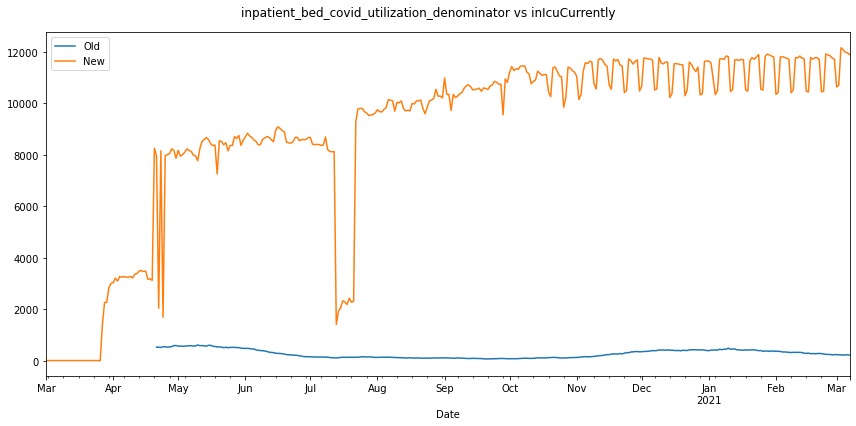




------------------------------------------------------------
deaths_covid


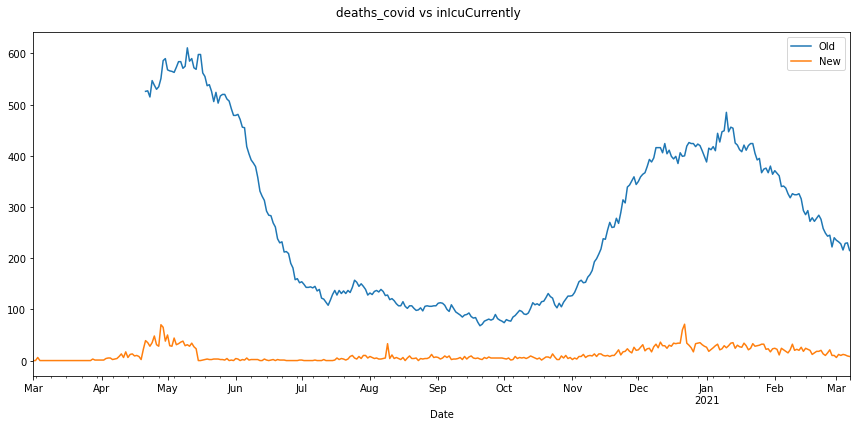




------------------------------------------------------------
percent_of_inpatients_with_covid


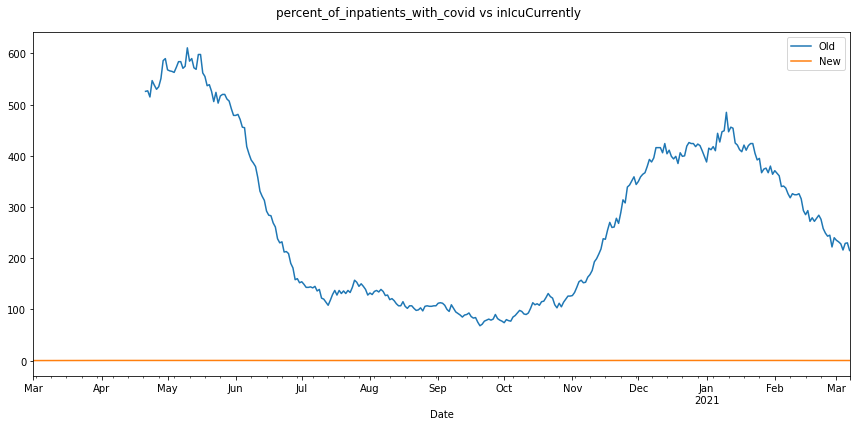




------------------------------------------------------------
inpatient_bed_covid_utilization_numerator


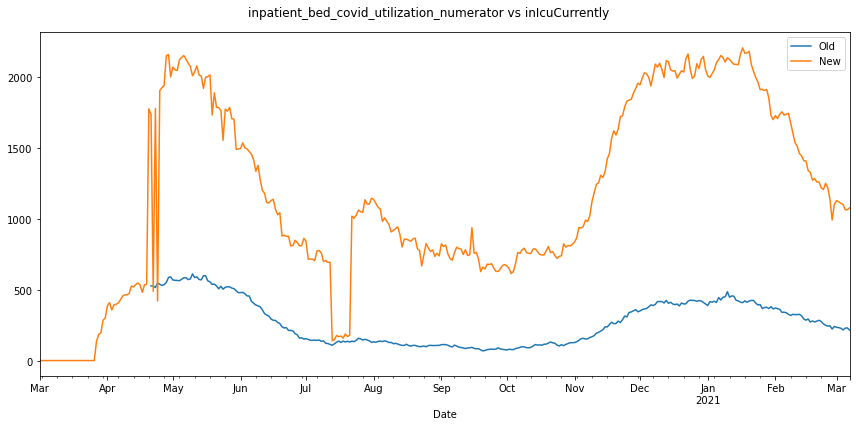




------------------------------------------------------------
deaths_covid_coverage


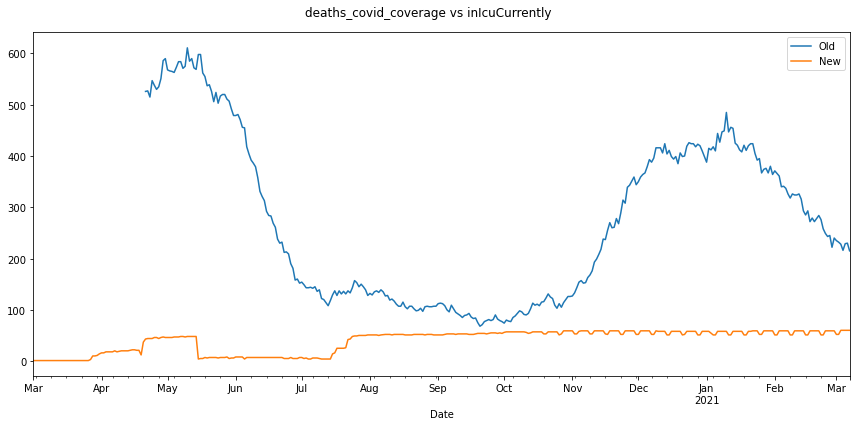




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid_coverage


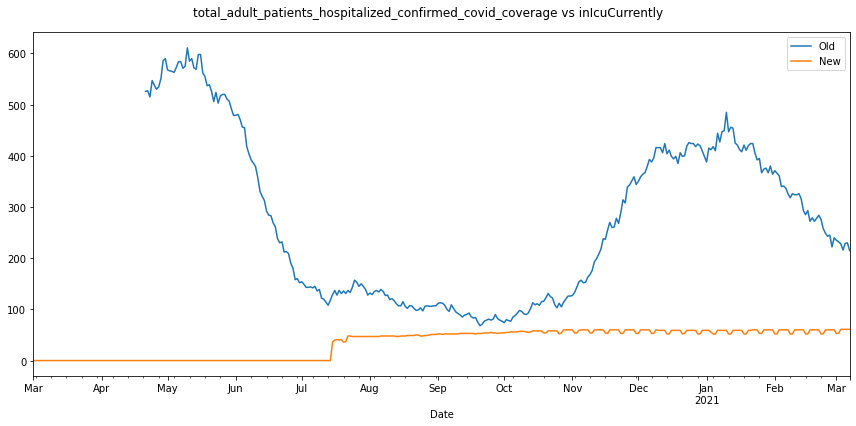




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_covid


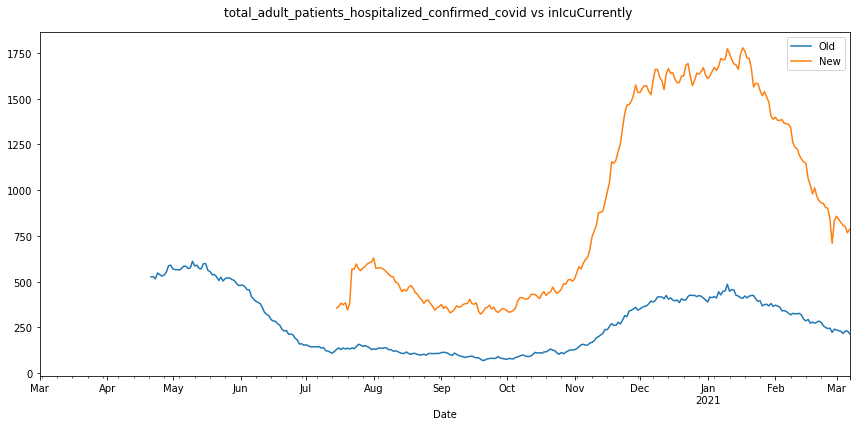




------------------------------------------------------------
inpatient_beds_coverage


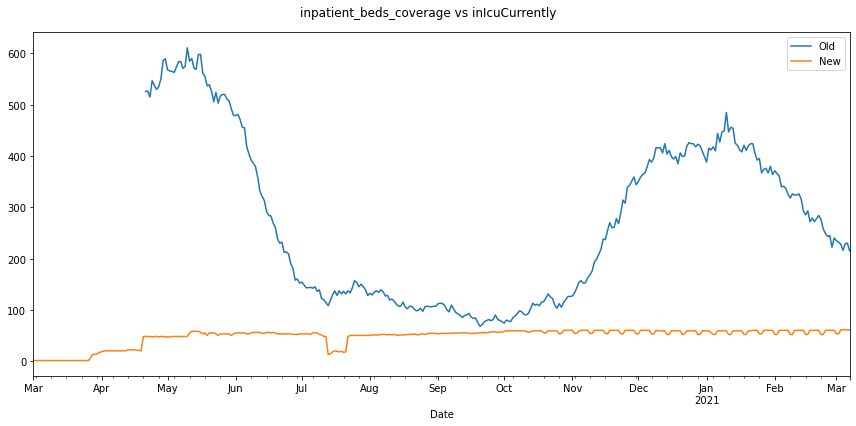




------------------------------------------------------------
inpatient_beds_utilization_denominator


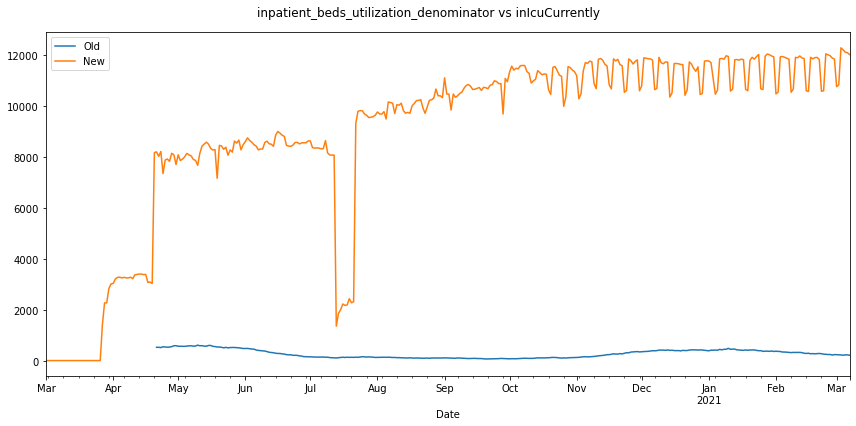




------------------------------------------------------------
inpatient_beds_utilization_coverage


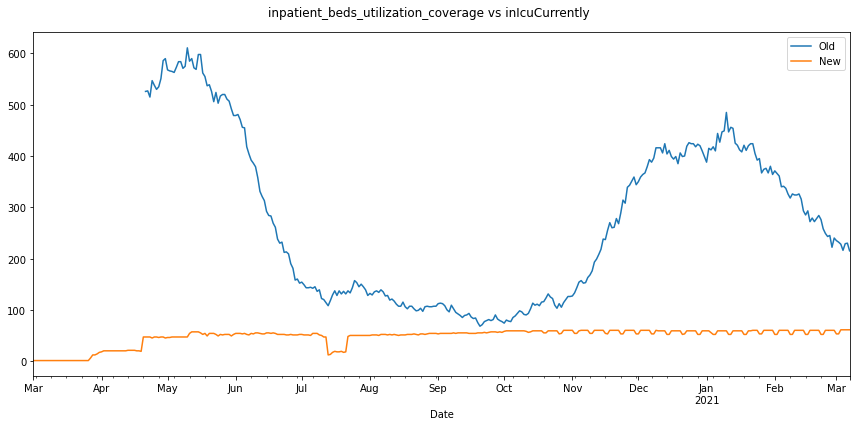




------------------------------------------------------------
staffed_adult_icu_bed_occupancy


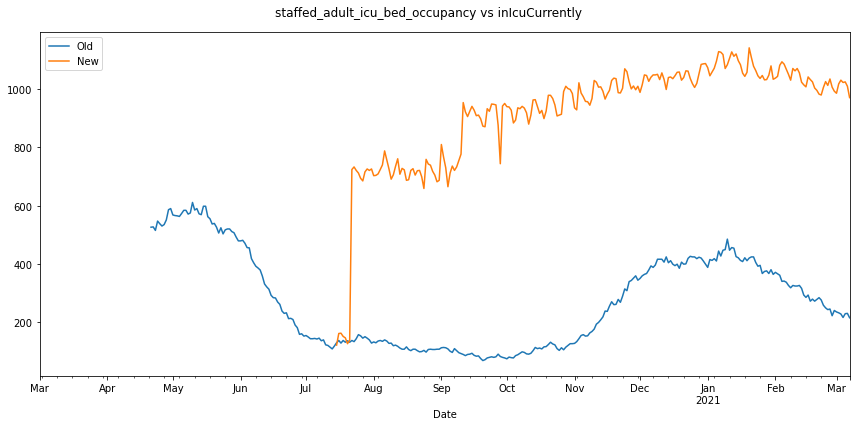




------------------------------------------------------------
inpatient_beds_used_coverage


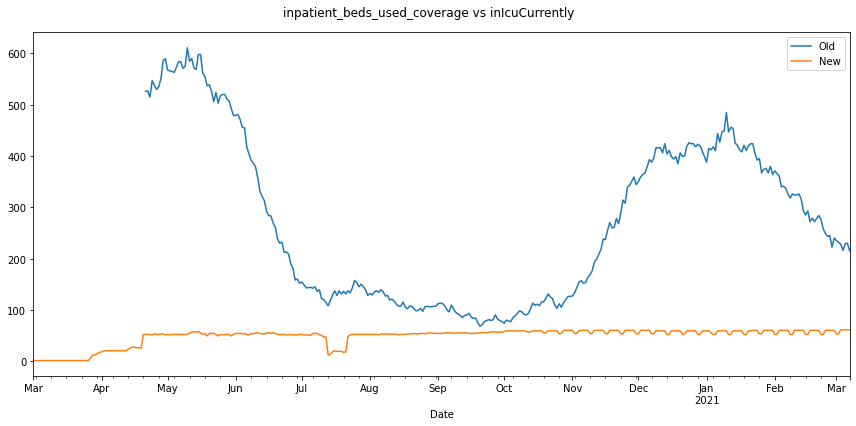




------------------------------------------------------------
adult_icu_bed_utilization_coverage


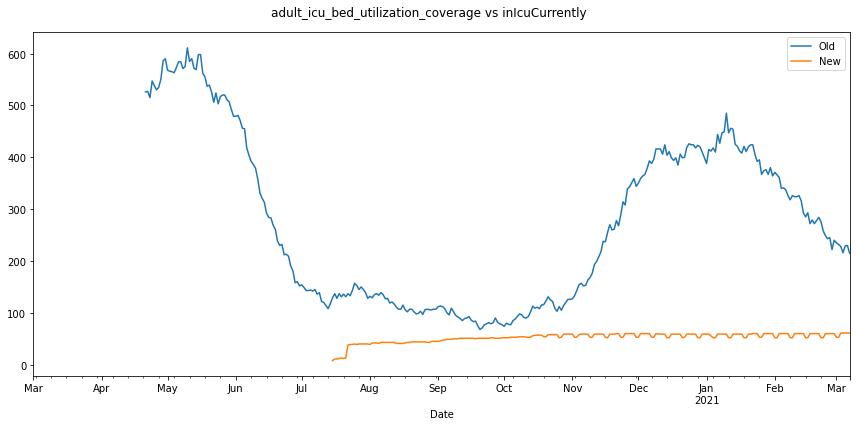




------------------------------------------------------------
inpatient_bed_covid_utilization


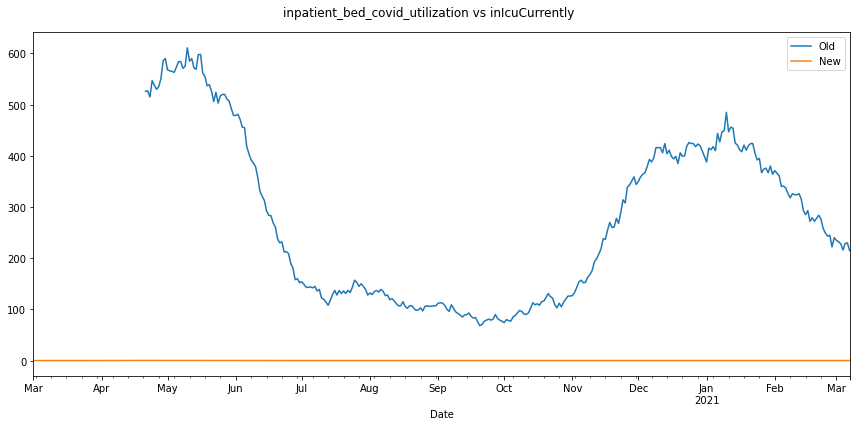




------------------------------------------------------------
total_adult_patients_hospitalized_confirmed_and_suspected_covid


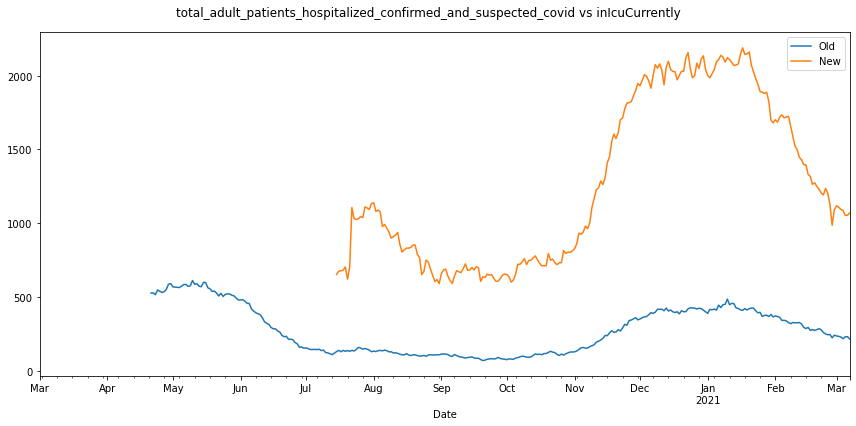




------------------------------------------------------------
adult_icu_bed_covid_utilization


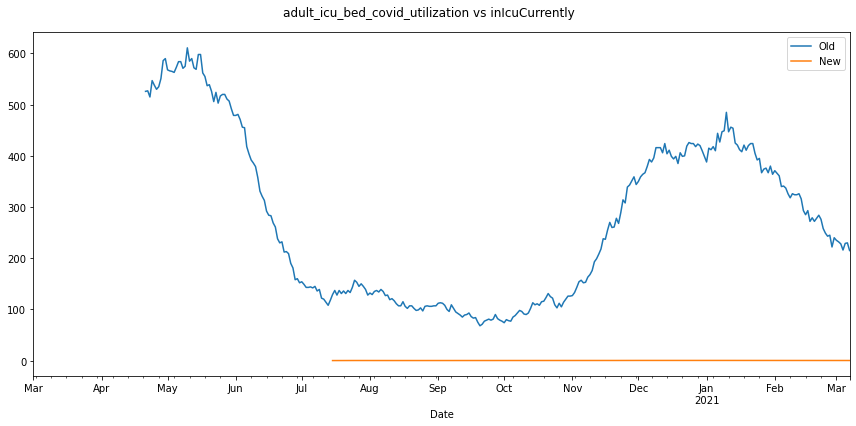




------------------------------------------------------------
percent_of_inpatients_with_covid_denominator


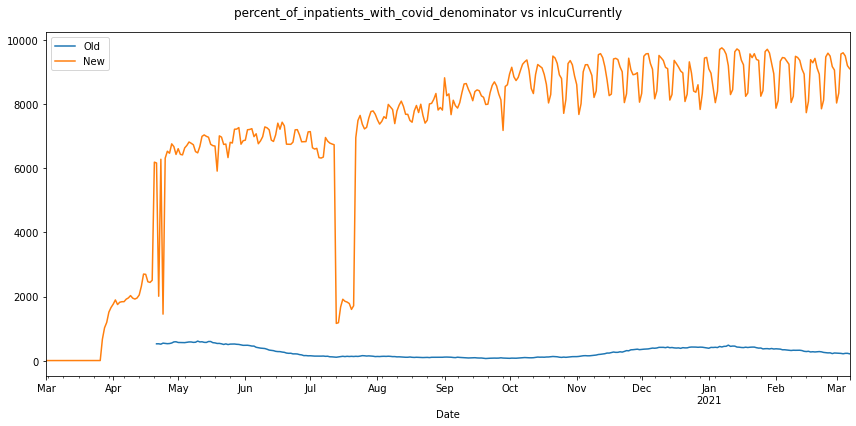

In [65]:
compare_old_vs_new_cols(old_md,new_md,old_col='inIcuCurrently')

### MATCHING COLUMNS
- old "hospitalizedCurrently" ==:
    - `total_adult_patients_hospitalized_confirmed_covid`
    - `inpatient_beds_used_covid`
    - `total_adult_patients_hospitalized_confirmed_covid`
    
- old "inIcuCurrently" ==:
    - `adult_icu_bed_covid_utilization_numerator`
        - Issue is that the new data source does not go back as far as old data source

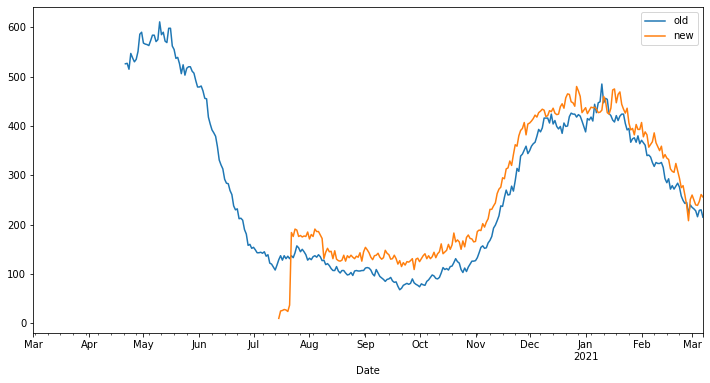

In [68]:
ax = old_md['inIcuCurrently'].plot(label='old')
new_md['adult_icu_bed_covid_utilization_numerator'].plot(ax=ax,label='new')
ax.legend()

### NY

In [ ]:
ny = get_state(STATES,'NY')
ny

In [ ]:
## make subplotsplot of time series # of cases vs utilization 
df_state = ny.copy()
drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
# df_state.drop(columns=drop_cols,inplace=True)
util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
other_cols = [c for c in df_state.columns if c not in util_cols]
util_cols

In [ ]:
df_state

In [ ]:
## 3 subplots
fig, axes = plt.subplots(nrows=4,figsize=(12,9))

# 1: cases
sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
             ax=axes[0],label='# Cases')#.plot(ax=axes[0])
# 2: deaths
sns.lineplot(data = df_state,x=df_state.index,color='red',
             y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

# 3: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization_numerator',
            ax=axes[2], color='darkgreen',label='inpatient_beds_utilization_numerator')

# 4: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization_numerator',
            ax=axes[3], color='darkred',label='adult_icu_bed_utilization_numerator')
plt.tight_layout()

In [ ]:
## Appending folder with functions
# %load_ext autoreload 
# %autoreload 2
# import sys
# sys.path.append('.')

# import functions as fn
# help(fn)

In [ ]:
def plot_state(df_state, title='State Covid Statistics',figsize=(10,8)):
    drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
    df_state.drop(columns=drop_cols,inplace=True)
    util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
    other_cols = [c for c in df_state.columns if c not in util_cols]

    ## 3 subplots
    fig, axes = plt.subplots(nrows=4,figsize=figsize)
    fig.suptitle(title)

    # 1: cases
    sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
                 ax=axes[0],label='# Cases')#.plot(ax=axes[0])
    # 2: deaths
    sns.lineplot(data = df_state,x=df_state.index,color='red',
                 y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

    # 3: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization',
                ax=axes[2], color='darkgreen',label='inpatient_beds_utilization')

    # 4: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization',
                ax=axes[3], color='darkred',label='adult_icu_bed_utilization')
    plt.tight_layout()
    return fig

In [ ]:
plot_state(ny);

# Time Series Modeling

## Functions

In [ ]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa

# def get_forecast(model,steps=12):
#     pred = model.get_forecast(steps=steps)
#     forecast = pred.conf_int()
#     forecast.columns = ['Lower CI','Upper CI']
#     forecast['Forecast'] = pred.predicted_mean
#     return forecast

    
# def plot_forecast(model,ts,last_n_lags=52,future_steps=12):
#     forecast_df = get_forecast(model,steps=future_steps)

#     fig,ax = plt.subplots(figsize=(12,5))
#     ts.iloc[-last_n_lags:].plot(label='True Data')
#     forecast_df['Forecast'].plot(ax=ax)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
#     ax.legend()
#     ax.set(title=f'Forecasted {ts.name}')
#     return fig,ax


# def evaluate_model(model,ts,last_n_lags =52,steps=12):
#     display(model.summary())
#     model.plot_diagnostics();
#     fig,ax=plot_forecast(model,ts,future_steps=steps,last_n_lags=last_n_lags)
#     return fig,ax

In [ ]:
from pmdarima import auto_arima

# def get_ts(df,col,fill_val=np.nan,**kwargs):
#     ts = df[col].fillna(value=fill_val)
#     return ts



# def get_best_model(ts,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,
#                    as_sarimax = True, **kwargs):
    
#     auto_model = auto_arima(ts,start_p=start_p,
#                             start_q=start_q,start_P=start_P,start_Q=start_Q,m=m,)
#     print(f"[i] Best parameters found:")
#     display(auto_model.summary())

#     if as_sarimax:
#         model = SARIMAX(ts,order=auto_model.order, 
#                 seasonal_order =auto_model.seasonal_order,
#                 enforce_invertibility=False,freq='D').fit()
#         return model

#     else:
#         return auto_model

# # def get_forecast(model,steps=14):
# #     forecast = model.get_forecast(steps=steps)
# #     forecast_df = forecast.conf_int()
# #     forecast_df['Forecast'] = forecast.predicted_mean
# #     forecast_df.columns = ['lower','upper','Forecast']
# #     return forecast_df

    
# def plot_forecast(model,ts,last_n_days=60,future_steps=14):
#     forecast_df = get_forecast(model,steps=future_steps)

#     fig,ax = plt.subplots(figsize=(12,5))
#     ts.iloc[-last_n_days:].plot(label='True Data')
#     forecast_df['forecast'].plot(ax=ax)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['lower'], forecast_df['upper'],alpha=0.6)
#     ax.legend()
#     ax.set(title=f'Forecasted {ts.name}')
#     return fig,ax

## NY

In [ ]:
plot_state(ny);

### Checking Seasonal Decompose for Seasonality to Use

In [ ]:
ts = ny['# Cases'].copy()
ts.plot()

### Number of Cases

In [ ]:
decomp = tsa.seasonal_decompose(ts)
decomp.plot();

In [ ]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

In [ ]:
fn.stationarity_check(ts.diff(7).dropna(),window=4)

In [ ]:
ts.plot()

In [ ]:
ts.shape[0]-30

In [ ]:
n=30

In [ ]:
def train_test_split_ts(ts,test_size=0.9,split_index=None):
    """Uses test size by default, split_index overrides it"""
    if split_index is not None:
        tts_cutoff = split_index
    else:
        tts_cutoff = round(ts.shape[0]*0.9)
    fmt = "%m-%d-%Y"
    cutoff_time = ts.index[tts_cutoff]
    print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
      ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]

    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    ax.set(ylabel=ts.name)
    ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
    ax.legend()
    ax.set_title(f"Train Test Split for {ts.name}")
    return train, test


In [ ]:
train,test = train_test_split_ts(ts,split_index=-30)

In [ ]:
# ## train test spit
# # get the tts_cutoff  (the # of timesteps/rows to split at)
# tts_cutoff = round(ts.shape[0]*0.9)
# tts_cutoff

In [ ]:
# ## Use the tts cutoff to do Train test split and plot
# train = ts.iloc[:tts_cutoff]
# test = ts.iloc[tts_cutoff:]

# ## Plot
# ax = train.plot(label='train')
# test.plot(label='test')
# ax.legend()

In [ ]:
## check staationarity 
fn.stationarity_check(train.diff(7).dropna(), window=7)

In [ ]:
m=7
fig,axes = plt.subplots(nrows=2, sharex=True)
tsa.graphics.plot_acf(train,ax=axes[0],title='Autocorrelation')

tsa.graphics.plot_acf(train.diff(m).dropna(),ax=axes[1],title=f'Autocorrelation-Post Differencing (m={m})');
[a.grid(which='both',axis='x') for a in axes]

In [ ]:
fig,axes = plt.subplots(nrows=2, sharex=True)
tsa.graphics.plot_pacf(train,ax=axes[0],title='Partial-Autocorrelation')

tsa.graphics.plot_pacf(train.diff(m).dropna(),ax=axes[1],title=f'Partial Autocorrelation-Post Differencing (m={m})');
[a.grid(which='both',axis='x') for a in axes]

> Add notes about COVID insights from acf/pacf

# BOOKMARK

In [ ]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout()
    
    
def get_df_from_pred(forecast_or_pred,forecast_label='Forecast'):
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    forecast_df = forecast_or_pred.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df[forecast_label] = forecast_or_pred.predicted_mean
    return forecast_df


def plot_forecast(model,ts,last_n_lags=365,future_steps=12):
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_lags:].plot(label='True Data')
    forecast_df['Forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    return fig,ax


### SHOULD I GET RID OF THIS FUNCTION?
def plot_forecast_from_df(forecast_df,ts_diff=None,orig_label='True Data',
                          forecast_label='Forecast',
                          last_n_lags=52,figsize=(10,4)):
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    fig,ax = plt.subplots(figsize=figsize)

    if ts_diff is not None:
        ts_diff.iloc[-last_n_lags:].plot(label='True Data')
        
   
    forecast_df['Forecast'].plot(ax=ax,label=forecast_label)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)
    ax.legend()
    ax.set(title=f'Forecasted {ts_diff.name}')
    return fig,ax
        
    
def get_forecast(model,steps=14):
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.columns = ['lower','upper','Forecast']
    return forecast_df
    
    
    
def evaluate_model(model,train,test,steps=None):
    diagnose_model(model)
    
    if steps is None:
        steps=len(test)
    
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = get_df_from_pred(forecast)
    
#     fig, ax = plot_forecast_from_df(forecast_df,ts_diff=ts,
#                                     last_n_lags=365)
    fig, ax = plot_forecast(model,train,future_steps=steps)
    
    if test is not None:
        test.plot(ax=ax,label='Test Data')
        ax.legend()
    return fig,ax
           

In [ ]:
from pmdarima import auto_arima

auto_model = auto_arima(train,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,trace=False)
auto_model.summary()

In [ ]:
model = tsa.SARIMAX(train,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

In [ ]:
# fn.plot_forecast(model,)
evaluate_model(model,train,test,)

In [ ]:
## Next: if happy, train on entire ts

In [ ]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

In [ ]:
plot_forecast(model, ts,last_n_lags=500)

## Old Data

In [ ]:
# covid = fn.CovidTrackingProject(verbose=True)
# covid

In [ ]:
# covid.df_states

## Updating Workflow Due to CovidTracking Project API shutting down

- Reverting to using Kaggle dataset. 


# UPDATING 

In [ ]:
cols_to_grab = ['# Cases','# Deaths','inpatient_beds_utilization','adult_icu_bed_utilization']
df_state = STATES['MD'][cols_to_grab].copy()
df_state

In [ ]:


# ## Get df for curr state and resample, keeping the last point for each day
# state_df = df.loc[df['state']==state]
# state_df = state_df.resample('D').last()

# ## save each col into its own dict key
# state_ts_dict = {}
# for col in cols_to_grab:
#     curr_ts = state_df[col].rename(f"{state}-{col}")
#     state_ts_dict[col] = curr_ts
# state_ts_dict

In [ ]:
# cols_to_grab = ['Confirmed','Deaths','Recovered']
# state_data = {}
# for state in state_list:

#     ## Get df for curr state and resample, keeping the last point for each day
#     state_df = df.loc[df['state']==state]
#     state_df = state_df.resample('D').last()

#     ## save each col into its own dict key
#     state_ts_dict = {}
#     for col in cols_to_grab:
#         curr_ts = state_df[col].rename(f"{state}-{col}")
#         state_ts_dict[col] = curr_ts
#     state_data[state] = pd.DataFrame(state_ts_dict)

In [ ]:
# ## pull out md confirmed
# ts = state_data['MD']#['Confirmed']
# ts

# TEST MODELING

In [ ]:
df_state.columns

In [ ]:
ts = df_state['# Cases']
ts.plot()

In [ ]:
ts2 = df_state['adult_icu_bed_utilization']
ts2.plot()

In [ ]:
ts3 = df_state['# Deaths']
ts3.plot()

In [ ]:
##Getting forecast
forecast = model.get_forecast(steps=14)

forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.columns = ['lower','upper','forecast']
forecast_df

In [ ]:
last_n_days = 60
fig,ax = plt.subplots(figsize=(12,5))
ts.iloc[-last_n_days:].plot(label='True Data')
forecast_df['forecast'].plot(ax=ax)
ax.fill_between(forecast_df.index,
                forecast_df['lower'], forecast_df['upper'],alpha=0.6)
ax.legend()
ax.set(title='Forecasted Hospitalizations (Current) for Maryland')
# ax.plot()